seg4_paths_copy.txt file

get_data.py file

convert_one_hot.py file

> from only_affine_model

In [1]:
# ====================================================================
# Cell 1: Dependencies and Basic Setup
# ====================================================================
!pip install psutil scikit-learn seaborn nibabel -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.ndimage import map_coordinates
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm import tqdm
import time
import psutil
import os
from pathlib import Path
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dependencies loaded. Using device: {device}")

Mounted at /content/drive
Dependencies loaded. Using device: cpu


In [2]:
# ====================================================================
# Cell 2: Model Architecture Definitions
# ====================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path

class BaselineUNet(nn.Module):
    """Baseline 3D U-Net - matches original training exactly"""
    def __init__(self, in_channels=10, out_channels=3, base_channels=32):
        super(BaselineUNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.InstanceNorm3d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.InstanceNorm3d(out_channels),
                nn.ReLU(inplace=True),
            )

        def upsample_block(in_channels, out_channels):
            return nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)

        # Encoder
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.enc4 = conv_block(128, 256)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = conv_block(256, 512)

        # Decoder
        self.up4 = upsample_block(512, 256)
        self.dec4 = conv_block(512, 256)
        self.up3 = upsample_block(256, 128)
        self.dec3 = conv_block(256, 128)
        self.up2 = upsample_block(128, 64)
        self.dec2 = conv_block(128, 64)
        self.up1 = upsample_block(64, 32)
        self.dec1 = conv_block(64, 32)

        # Output
        self.out_conv = nn.Conv3d(32, 3, kernel_size=1)

    def forward(self, x):
        # Encoder part
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)
        b = self.bottleneck(p4)

        # Decoder part
        up4 = self.up4(b)
        d4 = self.dec4(torch.cat((up4, e4), dim=1))
        up3 = self.up3(d4)
        d3 = self.dec3(torch.cat((up3, e3), dim=1))
        up2 = self.up2(d3)
        d2 = self.dec2(torch.cat((up2, e2), dim=1))
        up1 = self.up1(d2)
        d1 = self.dec1(torch.cat((up1, e1), dim=1))

        deformation_field = self.out_conv(d1)
        return deformation_field


class RegLossUNet(nn.Module):
    """U-Net with regularization and tanh scaling"""
    def __init__(self, in_channels=10, out_channels=3, base_channels=32):
        super(RegLossUNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.InstanceNorm3d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.InstanceNorm3d(out_channels),
                nn.ReLU(inplace=True),
            )

        def upsample_block(in_channels, out_channels):
            return nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)

        # Same architecture as baseline
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.enc4 = conv_block(128, 256)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(256, 512)

        self.up4 = upsample_block(512, 256)
        self.dec4 = conv_block(512, 256)
        self.up3 = upsample_block(256, 128)
        self.dec3 = conv_block(256, 128)
        self.up2 = upsample_block(128, 64)
        self.dec2 = conv_block(128, 64)
        self.up1 = upsample_block(64, 32)
        self.dec1 = conv_block(64, 32)

        # Output layer with initialization for small displacements
        self.out_conv = nn.Conv3d(32, 3, kernel_size=1)
        nn.init.normal_(self.out_conv.weight, 0, 0.01)
        nn.init.zeros_(self.out_conv.bias)

    def forward(self, x):
        # Same forward pass as baseline
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)
        b = self.bottleneck(p4)

        up4 = self.up4(b)
        d4 = self.dec4(torch.cat((up4, e4), dim=1))
        up3 = self.up3(d4)
        d3 = self.dec3(torch.cat((up3, e3), dim=1))
        up2 = self.up2(d3)
        d2 = self.dec2(torch.cat((up2, e2), dim=1))
        up1 = self.up1(d2)
        d1 = self.dec1(torch.cat((up1, e1), dim=1))

        deformation_field = self.out_conv(d1)
        # Key difference: tanh scaling for controlled deformation
        deformation_field = torch.tanh(deformation_field) * 0.3
        return deformation_field


class AffineParameterPredictor(nn.Module):
    """3D CNN for predicting affine transformation parameters"""
    def __init__(self, in_channels=10):
        super(AffineParameterPredictor, self).__init__()

        # Memory-efficient encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),
            nn.Conv3d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),
            nn.AdaptiveAvgPool3d(1)
        )

        # FC layers
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 12)  # 12 affine parameters
        )

        self._init_weights()

    def _init_weights(self):
        # Initialize to output identity transformation
        with torch.no_grad():
            identity = torch.tensor([1,0,0,0, 0,1,0,0, 0,0,1,0], dtype=torch.float32)
            self.fc[-1].weight.data.zero_()
            self.fc[-1].bias.data.copy_(identity)

    def forward(self, x):
        features = self.encoder(x)
        features = features.view(features.size(0), -1)
        affine_params = self.fc(features)
        return affine_params.view(-1, 3, 4)  # Reshape to 3x4 affine matrix


class AffineSpatialTransformer(nn.Module):
    """Applies affine transformation to input tensor"""
    def __init__(self, size):
        super(AffineSpatialTransformer, self).__init__()
        D, H, W = size

        # Create normalized coordinate grid
        z, y, x = torch.meshgrid(
            torch.linspace(-1, 1, D),
            torch.linspace(-1, 1, H),
            torch.linspace(-1, 1, W),
            indexing="ij"
        )
        grid = torch.stack([x, y, z], dim=-1)
        self.register_buffer("grid", grid.view(1, D, H, W, 3))

    def forward(self, x, affine):
        B, C, D, H, W = x.shape

        # Expand grid for batch
        grid = self.grid.expand(B, -1, -1, -1, -1)
        ones = torch.ones(B, D, H, W, 1, device=x.device)
        grid_h = torch.cat([grid, ones], dim=-1)  # Homogeneous coordinates

        # Apply affine transformation
        grid_affine = torch.matmul(grid_h.view(B, -1, 4), affine.transpose(1, 2))
        grid_affine = grid_affine.view(B, D, H, W, 3)

        # Clamp to valid range
        grid_affine = torch.clamp(grid_affine, -1.1, 1.1)

        warped = F.grid_sample(x, grid_affine, mode="bilinear", align_corners=False, padding_mode="border")
        return warped


class SpatialTransformer(nn.Module):
    """Dense STN for 3D one-hot maps with dynamic identity grid"""
    def __init__(self, size=None, device='cpu'):
        super().__init__()
        self.size = size
        if size is not None:
            D, H, W = size
            lin_z = torch.linspace(-1, 1, D, device=device)
            lin_y = torch.linspace(-1, 1, H, device=device)
            lin_x = torch.linspace(-1, 1, W, device=device)
            zz, yy, xx = torch.meshgrid(lin_z, lin_y, lin_x, indexing='ij')
            id_grid = torch.stack((xx, yy, zz), dim=-1)
            self.register_buffer('id_grid', id_grid.unsqueeze(0))
        else:
            self.register_buffer('id_grid', None)

    def forward(self, moving, flow):
        B, C, D, H, W = moving.shape
        flow = flow.permute(0, 2, 3, 4, 1)

        # Create dynamic grid if not pre-computed or size doesn't match
        if self.id_grid is None or self.id_grid.shape[1:4] != (D, H, W):
            lin_z = torch.linspace(-1, 1, D, device=moving.device)
            lin_y = torch.linspace(-1, 1, H, device=moving.device)
            lin_x = torch.linspace(-1, 1, W, device=moving.device)
            zz, yy, xx = torch.meshgrid(lin_z, lin_y, lin_x, indexing='ij')
            id_grid = torch.stack((xx, yy, zz), dim=-1).unsqueeze(0)
        else:
            id_grid = self.id_grid

        grid = id_grid.expand(B, -1, -1, -1, -1)
        warped_grid = grid + flow
        warped_grid = torch.clamp(warped_grid, -1.1, 1.1)

        warped = F.grid_sample(
            moving, warped_grid,
            mode='bilinear',
            padding_mode='border',
            align_corners=False
        )
        return warped


# Combined Model Wrappers for Proper Evaluation
class BaselineRegistrationModel(nn.Module):
    """Simple registration model - UNet + STN only (for baseline)"""
    def __init__(self, size=(128, 128, 128), num_channels=5):
        super().__init__()
        self.unet = BaselineUNet(in_channels=num_channels * 2, out_channels=3)
        self.stn = SpatialTransformer(size)

    def forward(self, source, target):
        x_input = torch.cat([source, target], dim=1)
        deformation_field = self.unet(x_input)
        warped_source = self.stn(source, deformation_field)
        return warped_source, deformation_field


class RegLossRegistrationModel(nn.Module):
    """Registration model with regularization losses - UNet + STN"""
    def __init__(self, size=(128, 128, 128), num_channels=5):
        super().__init__()
        self.unet = RegLossUNet(in_channels=num_channels * 2, out_channels=3)
        self.stn = SpatialTransformer(size)

    def forward(self, source, target):
        x_input = torch.cat([source, target], dim=1)
        deformation_field = self.unet(x_input)
        warped_source = self.stn(source, deformation_field)
        return warped_source, deformation_field


class CombinedRegistrationModel(nn.Module):
    """Combined affine + non-rigid registration model"""
    def __init__(self, size=(128, 128, 128), num_channels=5):
        super().__init__()
        self.affine_predictor = AffineParameterPredictor(in_channels=num_channels * 2)
        self.affine_stn = AffineSpatialTransformer(size)
        self.unet = RegLossUNet(in_channels=num_channels * 2, out_channels=3)
        self.nonrigid_stn = SpatialTransformer(size)

    def forward(self, source, target):
        # First apply affine registration
        x_affine_input = torch.cat([source, target], dim=1)
        affine_matrix = self.affine_predictor(x_affine_input)
        source_affine = self.affine_stn(source, affine_matrix)

        # Then apply non-rigid registration
        x_unet_input = torch.cat([source_affine, target], dim=1)
        deformation_field = self.unet(x_unet_input)
        warped_source = self.nonrigid_stn(source_affine, deformation_field)

        return warped_source, affine_matrix, deformation_field, source_affine


print("Model architectures defined successfully!")

Model architectures defined successfully!


In [3]:
# ====================================================================
# Cell 3: Model Loading Functions
# ====================================================================

def load_baseline_model(checkpoint_path, device):
    """Load baseline U-Net model from checkpoint"""
    try:
        print(f"Loading Baseline U-Net: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Extract config with proper defaults
        config = checkpoint.get("model_config", {})
        in_channels = config.get("in_channels", 10)
        out_channels = config.get("out_channels", 3)
        size = config.get("size", (128, 128, 128))

        # Create the combined baseline model (UNet + STN)
        model = BaselineRegistrationModel(size=size, num_channels=5)

        # Handle different checkpoint formats
        if "model_state_dict" in checkpoint and "stn_state_dict" in checkpoint:
            # Load UNet and STN separately
            model.unet.load_state_dict(checkpoint["model_state_dict"])
            model.stn.load_state_dict(checkpoint["stn_state_dict"])
        elif "model_state_dict" in checkpoint:
            # Try to load the entire model
            model.load_state_dict(checkpoint["model_state_dict"], strict=False)
        else:
            # Fallback: assume checkpoint is the state dict
            model.load_state_dict(checkpoint, strict=False)

        model.to(device)
        model.eval()
        print(f"   ✅ Baseline loaded (in_channels={in_channels}, out_channels={out_channels})")
        return model

    except Exception as e:
        print(f"   ❌ Failed to load baseline model: {str(e)}")
        return None


def load_regloss_model(checkpoint_path, device):
    """Load regularization loss U-Net model from checkpoint"""
    try:
        print(f"Loading RegLoss U-Net: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        config = checkpoint.get("model_config", {})
        in_channels = config.get("input_channels", config.get("in_channels", 10))
        out_channels = config.get("output_channels", config.get("out_channels", 3))
        size = config.get("size", (128, 128, 128))

        # Create the combined reg loss model (RegLoss UNet + STN)
        model = RegLossRegistrationModel(size=size, num_channels=5)

        # Handle different checkpoint formats
        if "model_state_dict" in checkpoint and "stn_state_dict" in checkpoint:
            model.unet.load_state_dict(checkpoint["model_state_dict"])
            model.stn.load_state_dict(checkpoint["stn_state_dict"])
        elif "model_state_dict" in checkpoint:
            model.load_state_dict(checkpoint["model_state_dict"], strict=False)
        else:
            model.load_state_dict(checkpoint, strict=False)

        model.to(device)
        model.eval()
        print(f"   ✅ RegLoss loaded (in_channels={in_channels}, out_channels={out_channels})")
        return model

    except Exception as e:
        print(f"   ❌ Failed to load RegLoss model: {str(e)}")
        return None


def load_combined_model(checkpoint_path, device, size=(128, 128, 128), num_channels=5):
    """Load combined (affine + non-rigid) model from checkpoint"""
    try:
        print(f"Loading Combined Model: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        config = checkpoint.get("model_config", {})
        volume_size = config.get("volume_size", size)
        model_num_channels = config.get("num_channels", num_channels)

        # Use the combined model that matches your training architecture
        model = CombinedRegistrationModel(size=volume_size, num_channels=model_num_channels)

        # Load state dict
        if "model_state_dict" in checkpoint:
            model.load_state_dict(checkpoint["model_state_dict"], strict=False)
        else:
            # Try loading individual components if available
            if "affine_predictor_state_dict" in checkpoint:
                model.affine_predictor.load_state_dict(checkpoint["affine_predictor_state_dict"])
            if "affine_stn_state_dict" in checkpoint:
                model.affine_stn.load_state_dict(checkpoint["affine_stn_state_dict"])
            if "unet_state_dict" in checkpoint:
                model.unet.load_state_dict(checkpoint["unet_state_dict"])
            if "nonrigid_stn_state_dict" in checkpoint:
                model.nonrigid_stn.load_state_dict(checkpoint["nonrigid_stn_state_dict"])

        model.to(device)
        model.eval()
        print(f"   ✅ Combined loaded (volume_size={volume_size}, num_channels={model_num_channels})")
        return model

    except Exception as e:
        print(f"   ❌ Failed to load combined model: {str(e)}")
        return None


def get_model_configs():
    """Get model configurations"""
    return [
        {
            'name': 'Baseline UNet',
            'description': 'Standard 3D U-Net baseline',
            'path': '/content/drive/MyDrive/segmentation-project/original_unet_model.pth',
            'loader': load_baseline_model,
            'color': '#e74c3c',  # Red
            'type': 'baseline'
        },
        {
            'name': 'RegLoss UNet',
            'description': 'U-Net with regularization losses',
            'path': '/content/drive/MyDrive/segmentation-project/regloss_model_latest.pth',
            'loader': load_regloss_model,
            'color': '#3498db',  # Blue
            'type': 'regloss_only'
        },
        {
            'name': 'Combined (Basic Loss)',
            'description': 'Affine + NonRigid with basic composite loss',
            'path': '/content/drive/MyDrive/segmentation-project/affine_unet_model.pth',
            'loader': load_combined_model,
            'color': '#f39c12',  # Orange
            'type': 'combined_basic'
        },
        {
            'name': 'Combined (Reg Loss)',
            'description': 'Affine + NonRigid with regularization losses',
            'path': '/content/drive/MyDrive/segmentation-project/fully_enhanced_model.pth',
            'loader': load_combined_model,
            'color': '#27ae60',  # Green
            'type': 'combined_enhanced'
        }
    ]

print("Model loading functions defined!")

Model loading functions defined!


In [4]:
# ====================================================================
# Cell 4: Test Model Loading
# ====================================================================

print("="*80)
print("TESTING MODEL LOADING")
print("="*80)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    torch.cuda.empty_cache()
else:
    print("⚠️ GPU not available - using CPU (this will be slow!)")

model_configs = get_model_configs()
loaded_models = []

# Test loading each model
for config in model_configs:
    print(f"\n--- Testing {config['name']} ---")
    if Path(config['path']).exists():
        print(f"✅ File exists: {config['path']}")

        # Try to load the model
        model = config['loader'](config['path'], device)
        if model is not None:
            config['model'] = model
            loaded_models.append(config)

            # Test model with correct training size (128x128x128)
            try:
                with torch.no_grad():
                    dummy_moving = torch.randn(1, 5, 128, 128, 128).to(device)
                    dummy_fixed = torch.randn(1, 5, 128, 128, 128).to(device)
                    outputs = model(dummy_moving, dummy_fixed)
                    print(f"   ✅ Forward pass successful: {len(outputs)} outputs returned")
                    for i, out in enumerate(outputs):
                        if torch.is_tensor(out):
                            print(f"      Output {i}: {out.shape}")

            except Exception as forward_error:
                print(f"   ⚠️  Forward pass failed: {str(forward_error)}")
                print("   (Model loaded but may need architecture adjustments)")

            print(f"   ✅ {config['name']}: Successfully loaded and tested")

        else:
            print(f"   ❌ {config['name']}: Failed to load")
    else:
        print(f"   ⚠️  File not found: {config['path']}")

print(f"\n" + "="*60)
print(f"MODEL LOADING TEST COMPLETE")
print(f"Successfully loaded and tested: {len(loaded_models)}/{len(model_configs)} models")
print("="*60)

if loaded_models:
    print("\n✅ LOADED MODELS:")
    for config in loaded_models:
        print(f"   - {config['name']} ({config['type']})")
else:
    print("\n❌ NO MODELS LOADED - Check file paths and architectures")

TESTING MODEL LOADING
Using device: cpu
⚠️ GPU not available - using CPU (this will be slow!)

--- Testing Baseline UNet ---
✅ File exists: /content/drive/MyDrive/segmentation-project/original_unet_model.pth
Loading Baseline U-Net: /content/drive/MyDrive/segmentation-project/original_unet_model.pth
   ✅ Baseline loaded (in_channels=10, out_channels=3)
   ✅ Forward pass successful: 2 outputs returned
      Output 0: torch.Size([1, 5, 128, 128, 128])
      Output 1: torch.Size([1, 3, 128, 128, 128])
   ✅ Baseline UNet: Successfully loaded and tested

--- Testing RegLoss UNet ---
✅ File exists: /content/drive/MyDrive/segmentation-project/regloss_model_latest.pth
Loading RegLoss U-Net: /content/drive/MyDrive/segmentation-project/regloss_model_latest.pth
   ✅ RegLoss loaded (in_channels=10, out_channels=3)
   ✅ Forward pass successful: 2 outputs returned
      Output 0: torch.Size([1, 5, 128, 128, 128])
      Output 1: torch.Size([1, 3, 128, 128, 128])
   ✅ RegLoss UNet: Successfully loaded

In [18]:
# ====================================================================
# Cell 5: Enhanced Registration Metrics Functions (FIXED)
# ====================================================================

def compute_enhanced_registration_metrics(moving_img, fixed_img, registered_img):
    """Compute enhanced registration metrics including all basic + advanced metrics - IMPROVED VERSION"""
    try:
        device = moving_img.device
        fixed_img = fixed_img.to(device)
        registered_img = registered_img.to(device)
        eps = 1e-8

        # ===== BASIC METRICS (UNCHANGED FOR COMPATIBILITY) =====
        # MSE metrics
        mse_original = torch.mean((moving_img - fixed_img) ** 2).item()
        mse_registered = torch.mean((registered_img - fixed_img) ** 2).item()
        mse_improvement = mse_original - mse_registered

        # Global NCC with stability
        def safe_ncc(img1, img2):
            img1_flat = img1.view(-1)
            img2_flat = img2.view(-1)
            mean1 = torch.mean(img1_flat)
            mean2 = torch.mean(img2_flat)
            centered1 = img1_flat - mean1
            centered2 = img2_flat - mean2
            numerator = torch.sum(centered1 * centered2)
            denominator = torch.sqrt(torch.sum(centered1**2) * torch.sum(centered2**2)) + eps
            return (numerator / denominator).item()

        ncc_original = safe_ncc(moving_img, fixed_img)
        ncc_registered = safe_ncc(registered_img, fixed_img)
        ncc_improvement = ncc_registered - ncc_original

        # SSIM approximation
        def safe_ssim(img1, img2):
            mu1 = torch.mean(img1)
            mu2 = torch.mean(img2)
            sigma1_sq = torch.var(img1) + eps
            sigma2_sq = torch.var(img2) + eps
            sigma12 = torch.mean((img1 - mu1) * (img2 - mu2))
            C1, C2 = 0.01**2, 0.03**2
            ssim = ((2*mu1*mu2 + C1) * (2*sigma12 + C2)) / ((mu1**2 + mu2**2 + C1) * (sigma1_sq + sigma2_sq + C2))
            return ssim.item()

        ssim_original = safe_ssim(moving_img, fixed_img)
        ssim_registered = safe_ssim(registered_img, fixed_img)
        ssim_improvement = ssim_registered - ssim_original

        # ===== ENHANCED METRICS (IMPROVED IMPLEMENTATIONS) =====

        # 1. IMPROVED Local NCC
        def compute_local_ncc_improved(img1, img2):
            """Compute NCC over local regions using better sampling"""
            try:
                B, C, D, H, W = img1.shape
                # Use overlapping windows for better coverage
                window_size = min(16, D//2, H//2, W//2)
                if window_size < 4:
                    return safe_ncc(img1, img2)  # Fallback to global NCC

                stride = max(1, window_size // 2)
                local_nccs = []

                # Sample windows across the volume
                for i in range(0, D-window_size+1, stride):
                    for j in range(0, H-window_size+1, stride):
                        for k in range(0, W-window_size+1, stride):
                            if len(local_nccs) >= 50:  # Limit for efficiency
                                break

                            window1 = img1[:, :, i:i+window_size, j:j+window_size, k:k+window_size]
                            window2 = img2[:, :, i:i+window_size, j:j+window_size, k:k+window_size]

                            # Compute NCC for this window
                            ncc_val = safe_ncc(window1, window2)
                            if not np.isnan(ncc_val):
                                local_nccs.append(ncc_val)

                        if len(local_nccs) >= 50:
                            break
                    if len(local_nccs) >= 50:
                        break

                return np.mean(local_nccs) if local_nccs else 0.0
            except:
                return safe_ncc(img1, img2)  # Fallback

        local_ncc_original = compute_local_ncc_improved(moving_img, fixed_img)
        local_ncc_registered = compute_local_ncc_improved(registered_img, fixed_img)
        local_ncc_improvement = local_ncc_registered - local_ncc_original

        # 2. FIXED Gradient Correlation
        def compute_gradient_correlation_fixed(img1, img2):
            """Compute correlation between image gradients - FIXED VERSION"""
            try:
                B, C, D, H, W = img1.shape

                # Take middle slice and first channel to get 2D slice
                mid_slice = D // 2
                slice1 = img1[0, 0, mid_slice, :, :].unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
                slice2 = img2[0, 0, mid_slice, :, :].unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]

                # Check minimum size
                if slice1.shape[2] < 3 or slice1.shape[3] < 3:
                    return 0.0

                # Simple gradient using diff (more reliable than conv2d)
                grad1_x = torch.diff(slice1, dim=3)  # Gradient in x direction [1, 1, H, W-1]
                grad1_y = torch.diff(slice1, dim=2)  # Gradient in y direction [1, 1, H-1, W]
                grad2_x = torch.diff(slice2, dim=3)
                grad2_y = torch.diff(slice2, dim=2)

                # Match dimensions by cropping
                min_h = min(grad1_x.shape[2], grad1_y.shape[2], grad2_x.shape[2], grad2_y.shape[2])
                min_w = min(grad1_x.shape[3], grad1_y.shape[3], grad2_x.shape[3], grad2_y.shape[3])

                grad1_x = grad1_x[:, :, :min_h, :min_w]
                grad1_y = grad1_y[:, :, :min_h, :min_w]
                grad2_x = grad2_x[:, :, :min_h, :min_w]
                grad2_y = grad2_y[:, :, :min_h, :min_w]

                # Gradient magnitude
                grad1_mag = torch.sqrt(grad1_x**2 + grad1_y**2 + eps)
                grad2_mag = torch.sqrt(grad2_x**2 + grad2_y**2 + eps)

                # Flatten and compute correlation
                grad1_flat = grad1_mag.view(-1)
                grad2_flat = grad2_mag.view(-1)

                if len(grad1_flat) > 0:
                    mean1 = torch.mean(grad1_flat)
                    mean2 = torch.mean(grad2_flat)
                    centered1 = grad1_flat - mean1
                    centered2 = grad2_flat - mean2
                    numerator = torch.sum(centered1 * centered2)
                    denom = torch.sqrt(torch.sum(centered1**2) * torch.sum(centered2**2)) + eps
                    corr = (numerator / denom).item()
                    return corr if not np.isnan(corr) else 0.0

                return 0.0

            except Exception as e:
                print(f"Gradient correlation error: {e}")
                return 0.0

        gradient_corr_original = compute_gradient_correlation_fixed(moving_img, fixed_img)
        gradient_corr_registered = compute_gradient_correlation_fixed(registered_img, fixed_img)
        gradient_correlation = gradient_corr_registered  # Keep absolute value for compatibility

        # 3. FAST Mutual Information (much more efficient)
        def compute_mutual_information_fast(img1, img2):
            """Fast mutual information using efficient sampling"""
            try:
                # Much smaller sample for speed
                img1_flat = img1.view(-1)
                img2_flat = img2.view(-1)

                # Use fixed small sample size for speed
                n_samples = min(5000, len(img1_flat))  # Reduced from 50000

                # Use stride sampling instead of randperm for speed
                stride = max(1, len(img1_flat) // n_samples)
                img1_sample = img1_flat[::stride][:n_samples]
                img2_sample = img2_flat[::stride][:n_samples]

                # Quick normalization
                img1_min, img1_max = img1_sample.min(), img1_sample.max()
                img2_min, img2_max = img2_sample.min(), img2_sample.max()

                if img1_max - img1_min < eps or img2_max - img2_min < eps:
                    return 0.0

                img1_norm = (img1_sample - img1_min) / (img1_max - img1_min + eps)
                img2_norm = (img2_sample - img2_min) / (img2_max - img2_min + eps)

                # Smaller bins for speed
                bins = 16  # Reduced from 32
                img1_bins = (img1_norm * (bins - 1)).long()
                img2_bins = (img2_norm * (bins - 1)).long()

                img1_bins = torch.clamp(img1_bins, 0, bins - 1)
                img2_bins = torch.clamp(img2_bins, 0, bins - 1)

                # Fast histogram using bincount
                joint_indices = img1_bins * bins + img2_bins
                joint_hist = torch.bincount(joint_indices, minlength=bins*bins).float()
                joint_hist = joint_hist.view(bins, bins)

                if joint_hist.sum() < eps:
                    return 0.0

                joint_hist = joint_hist / joint_hist.sum()

                # Marginal distributions
                p_x = joint_hist.sum(dim=1)
                p_y = joint_hist.sum(dim=0)

                # Vectorized MI calculation (much faster)
                mask = (joint_hist > eps) & (p_x.unsqueeze(1) > eps) & (p_y.unsqueeze(0) > eps)
                if mask.sum() == 0:
                    return 0.0

                joint_masked = joint_hist[mask]
                marginal_product = (p_x.unsqueeze(1) * p_y.unsqueeze(0))[mask]

                mi = torch.sum(joint_masked * torch.log(joint_masked / marginal_product))
                return mi.item()

            except Exception as e:
                print(f"MI computation error: {e}")
                return 0.0

        mi_original = compute_mutual_information_fast(moving_img, fixed_img)
        mi_registered = compute_mutual_information_fast(registered_img, fixed_img)
        mutual_information = mi_registered  # Keep absolute value for compatibility

        # 4. IMPROVED Local SSIM (keep original name)
        def compute_local_ssim_mean_improved(img1, img2):
            """Compute mean SSIM over local regions - improved"""
            try:
                B, C, D, H, W = img1.shape
                window_size = min(16, D//2, H//2, W//2)
                if window_size < 4:
                    return safe_ssim(img1, img2)

                stride = window_size // 2
                ssim_values = []

                # Sample local regions
                for i in range(0, D-window_size+1, stride):
                    for j in range(0, H-window_size+1, stride):
                        for k in range(0, W-window_size+1, stride):
                            if len(ssim_values) >= 20:  # Limit for efficiency
                                break

                            patch1 = img1[:, :, i:i+window_size, j:j+window_size, k:k+window_size]
                            patch2 = img2[:, :, i:i+window_size, j:j+window_size, k:k+window_size]

                            ssim_val = safe_ssim(patch1, patch2)
                            if not np.isnan(ssim_val):
                                ssim_values.append(ssim_val)

                        if len(ssim_values) >= 20:
                            break
                    if len(ssim_values) >= 20:
                        break

                return np.mean(ssim_values) if ssim_values else safe_ssim(img1, img2)
            except:
                return safe_ssim(img1, img2)

        local_ssim_original = compute_local_ssim_mean_improved(moving_img, fixed_img)
        local_ssim_registered = compute_local_ssim_mean_improved(registered_img, fixed_img)
        local_ssim_mean = local_ssim_registered  # Keep absolute value for compatibility

        # Combine all metrics - KEEP EXACT SAME FORMAT FOR COMPATIBILITY
        enhanced_metrics = {
            # Basic metrics (unchanged)
            'mse_original': mse_original,
            'mse_registered': mse_registered,
            'mse_improvement': mse_improvement,
            'ncc_original': ncc_original,
            'ncc_registered': ncc_registered,
            'ncc_improvement': ncc_improvement,
            'ssim_original': ssim_original,
            'ssim_registered': ssim_registered,
            'ssim_improvement': ssim_improvement,

            # Enhanced metrics (same names, improved implementations)
            'local_ncc_improvement': local_ncc_improvement,
            'gradient_correlation': gradient_correlation,  # Now should be non-zero
            'mutual_information': mutual_information,
            'local_ssim_mean': local_ssim_mean
        }

        return enhanced_metrics

    except Exception as e:
        print(f"Warning: Error computing enhanced registration metrics: {e}")
        return {
            'mse_original': 0, 'mse_registered': 0, 'mse_improvement': 0,
            'ncc_original': 0, 'ncc_registered': 0, 'ncc_improvement': 0,
            'ssim_original': 0, 'ssim_registered': 0, 'ssim_improvement': 0,
            'local_ncc_improvement': 0, 'gradient_correlation': 0,
            'mutual_information': 0, 'local_ssim_mean': 0
        }


def compute_enhanced_deformation_metrics(deformation_field):
    """Compute enhanced deformation field quality metrics - IMPROVED VERSION"""
    if deformation_field is None:
        return {
            'max_displacement': 0, 'mean_displacement': 0, 'std_displacement': 0,
            'jacobian_determinant_mean': 1.0, 'jacobian_determinant_std': 0.0,
            'negative_jacobian_ratio': 0.0, 'folding_count': 0,
            'smoothness_score': 0.0, 'local_rigidity_score': 0.0,
            'boundary_preservation_score': 0.0, 'anatomical_plausibility_score': 0.0,
            'deformation_magnitude_distribution': [0]*5, 'has_field': False
        }

    try:
        device = deformation_field.device
        B, C, D, H, W = deformation_field.shape
        eps = 1e-8

        # Basic displacement analysis (unchanged for compatibility)
        displacement_magnitude = torch.norm(deformation_field, dim=1)
        max_displacement = torch.max(displacement_magnitude).item()
        mean_displacement = torch.mean(displacement_magnitude).item()
        std_displacement = torch.std(displacement_magnitude).item()

        # IMPROVED Jacobian determinant analysis
        def compute_jacobian_determinant_3d_improved(deformation_field):
            """MUCH IMPROVED 3D Jacobian determinant computation"""
            try:
                B, C, D, H, W = deformation_field.shape

                # Use finite differences with proper boundary handling
                def finite_diff_3d(tensor, dim, spacing=1.0):
                    """Compute finite differences along specified dimension"""
                    if tensor.shape[dim] < 3:
                        return torch.zeros_like(tensor)

                    if dim == 2:  # z direction
                        diff = torch.zeros_like(tensor)
                        diff[:, :, 1:-1, :, :] = (tensor[:, :, 2:, :, :] - tensor[:, :, :-2, :, :]) / (2 * spacing)
                        diff[:, :, 0, :, :] = tensor[:, :, 1, :, :] - tensor[:, :, 0, :, :]
                        diff[:, :, -1, :, :] = tensor[:, :, -1, :, :] - tensor[:, :, -2, :, :]
                    elif dim == 3:  # y direction
                        diff = torch.zeros_like(tensor)
                        diff[:, :, :, 1:-1, :] = (tensor[:, :, :, 2:, :] - tensor[:, :, :, :-2, :]) / (2 * spacing)
                        diff[:, :, :, 0, :] = tensor[:, :, :, 1, :] - tensor[:, :, :, 0, :]
                        diff[:, :, :, -1, :] = tensor[:, :, :, -1, :] - tensor[:, :, :, -2, :]
                    elif dim == 4:  # x direction
                        diff = torch.zeros_like(tensor)
                        diff[:, :, :, :, 1:-1] = (tensor[:, :, :, :, 2:] - tensor[:, :, :, :, :-2]) / (2 * spacing)
                        diff[:, :, :, :, 0] = tensor[:, :, :, :, 1] - tensor[:, :, :, :, 0]
                        diff[:, :, :, :, -1] = tensor[:, :, :, :, -1] - tensor[:, :, :, :, -2]

                    return diff

                # Compute all partial derivatives
                # u = displacement in x, v = displacement in y, w = displacement in z
                u = deformation_field[:, 0, :, :, :]  # x-component
                v = deformation_field[:, 1, :, :, :]  # y-component
                w = deformation_field[:, 2, :, :, :]  # z-component

                # Partial derivatives
                du_dx = finite_diff_3d(u.unsqueeze(1), dim=4).squeeze(1)  # ∂u/∂x
                du_dy = finite_diff_3d(u.unsqueeze(1), dim=3).squeeze(1)  # ∂u/∂y
                du_dz = finite_diff_3d(u.unsqueeze(1), dim=2).squeeze(1)  # ∂u/∂z

                dv_dx = finite_diff_3d(v.unsqueeze(1), dim=4).squeeze(1)  # ∂v/∂x
                dv_dy = finite_diff_3d(v.unsqueeze(1), dim=3).squeeze(1)  # ∂v/∂y
                dv_dz = finite_diff_3d(v.unsqueeze(1), dim=2).squeeze(1)  # ∂v/∂z

                dw_dx = finite_diff_3d(w.unsqueeze(1), dim=4).squeeze(1)  # ∂w/∂x
                dw_dy = finite_diff_3d(w.unsqueeze(1), dim=3).squeeze(1)  # ∂w/∂y
                dw_dz = finite_diff_3d(w.unsqueeze(1), dim=2).squeeze(1)  # ∂w/∂z

                # Jacobian matrix is I + grad(displacement)
                # J = |1+∂u/∂x  ∂u/∂y   ∂u/∂z |
                #     |∂v/∂x    1+∂v/∂y ∂v/∂z |
                #     |∂w/∂x    ∂w/∂y   1+∂w/∂z|

                # Compute 3x3 determinant
                jacobian_det = (
                    (1 + du_dx) * ((1 + dv_dy) * (1 + dw_dz) - dv_dz * dw_dy) -
                    du_dy * (dv_dx * (1 + dw_dz) - dv_dz * dw_dx) +
                    du_dz * (dv_dx * dw_dy - (1 + dv_dy) * dw_dx)
                )

                return jacobian_det

            except Exception as e:
                print(f"Warning in improved jacobian computation: {e}")
                # Better fallback - use displacement magnitude to estimate jacobian
                displacement_magnitude = torch.norm(deformation_field, dim=1)
                # Assume small deformations: det(J) ≈ 1 - div(u) where div(u) ≈ |u|/scale
                return torch.ones_like(displacement_magnitude) * (1 - 0.1 * displacement_magnitude)

        jacobian_det = compute_jacobian_determinant_3d_improved(deformation_field)
        jacobian_mean = torch.mean(jacobian_det).item()
        jacobian_std = torch.std(jacobian_det).item()

        # Count negative jacobians (folding)
        negative_jacobians = (jacobian_det <= eps).sum().item()
        total_jacobians = jacobian_det.numel()
        negative_jacobian_ratio = negative_jacobians / max(1, total_jacobians)
        folding_count = negative_jacobians

        # SIMPLIFIED Smoothness analysis (fixed)
        def compute_smoothness_score_simplified(deformation_field):
            """Simplified but robust deformation field smoothness"""
            try:
                total_roughness = 0.0
                count = 0

                B, C, D, H, W = deformation_field.shape

                # Check minimum dimensions
                if D < 3 or H < 3 or W < 3:
                    return 0.5

                for dim in range(3):  # x, y, z components
                    component = deformation_field[:, dim, :, :, :]

                    # Simple second derivatives using diff
                    try:
                        if D > 2:
                            second_deriv_z = torch.diff(component, n=2, dim=1)  # Along D dimension
                            total_roughness += torch.mean(torch.abs(second_deriv_z)).item()
                            count += 1

                        if H > 2:
                            second_deriv_y = torch.diff(component, n=2, dim=2)  # Along H dimension
                            total_roughness += torch.mean(torch.abs(second_deriv_y)).item()
                            count += 1

                        if W > 2:
                            second_deriv_x = torch.diff(component, n=2, dim=3)  # Along W dimension
                            total_roughness += torch.mean(torch.abs(second_deriv_x)).item()
                            count += 1
                    except Exception as inner_e:
                        print(f"Inner smoothness error: {inner_e}")
                        continue

                if count == 0:
                    return 0.5

                avg_roughness = total_roughness / count
                # Convert to smoothness score (0 = rough, 1 = smooth)
                smoothness = np.exp(-avg_roughness * 5)  # Reduced multiplier
                return max(0.0, min(1.0, smoothness))

            except Exception as e:
                print(f"Smoothness computation error: {e}")
                return 0.5  # Neutral value

        smoothness_score = compute_smoothness_score_simplified(deformation_field)

        # KEEP ALL OTHER FUNCTIONS UNCHANGED FOR COMPATIBILITY
        # Local rigidity score (measures how uniform deformation is locally)
        def compute_local_rigidity_score(deformation_field):
            """Measure local rigidity of deformation"""
            try:
                # Use pooling to measure local variation
                if all(s > 8 for s in deformation_field.shape[2:]):
                    pooled_def = F.avg_pool3d(deformation_field, kernel_size=8, stride=4, padding=2)
                    local_variance = torch.var(pooled_def, dim=(2, 3, 4))
                    rigidity = torch.exp(-torch.mean(local_variance))
                    return rigidity.item()
                else:
                    return 0.5
            except:
                return 0.5

        local_rigidity_score = compute_local_rigidity_score(deformation_field)

        # Boundary preservation (check if deformation is smaller at boundaries)
        def compute_boundary_preservation_score(deformation_field):
            """Measure how well boundaries are preserved"""
            try:
                B, C, D, H, W = deformation_field.shape

                if D < 4 or H < 4 or W < 4:
                    return 1.0  # Small volumes - assume good preservation

                # Extract boundary slices
                boundary_slices = [
                    deformation_field[:, :, 0, :, :],      # front
                    deformation_field[:, :, -1, :, :],     # back
                    deformation_field[:, :, :, 0, :],      # top
                    deformation_field[:, :, :, -1, :],     # bottom
                    deformation_field[:, :, :, :, 0],      # left
                    deformation_field[:, :, :, :, -1],     # right
                ]

                boundary_magnitude = torch.mean(torch.stack([torch.norm(slice_def, dim=1)
                                                            for slice_def in boundary_slices]))
                interior_magnitude = torch.mean(torch.norm(deformation_field[:, :, 1:-1, 1:-1, 1:-1], dim=1))

                # Good boundary preservation means smaller deformation at boundaries
                preservation_score = torch.exp(-(boundary_magnitude / (interior_magnitude + eps)))
                return preservation_score.item()
            except:
                return 0.5

        boundary_preservation_score = compute_boundary_preservation_score(deformation_field)

        # Anatomical plausibility score (combined measure)
        anatomical_plausibility_score = (
            0.4 * max(0, min(1, 2 - abs(jacobian_mean - 1.0))) +  # Close to volume preserving
            0.3 * smoothness_score +                              # Smooth deformation
            0.2 * max(0, min(1, 1 - negative_jacobian_ratio)) +   # Few foldings
            0.1 * local_rigidity_score                            # Locally rigid
        )

        # Deformation magnitude distribution (percentiles) - UNCHANGED
        displacement_flat = displacement_magnitude.view(-1)
        try:
            percentiles = [0, 25, 50, 75, 100]
            deformation_distribution = [torch.quantile(displacement_flat, p/100.0).item()
                                      for p in percentiles]
        except:
            deformation_distribution = [0, 0, mean_displacement, mean_displacement*1.5, max_displacement]

        # RETURN EXACT SAME FORMAT FOR COMPATIBILITY
        return {
            'max_displacement': max_displacement,
            'mean_displacement': mean_displacement,
            'std_displacement': std_displacement,
            'jacobian_determinant_mean': jacobian_mean,
            'jacobian_determinant_std': jacobian_std,
            'negative_jacobian_ratio': negative_jacobian_ratio,
            'folding_count': folding_count,
            'smoothness_score': smoothness_score,  # Now should be non-zero
            'local_rigidity_score': local_rigidity_score,
            'boundary_preservation_score': boundary_preservation_score,
            'anatomical_plausibility_score': anatomical_plausibility_score,
            'deformation_magnitude_distribution': deformation_distribution,
            'has_field': True
        }

    except Exception as e:
        print(f"Warning: Error analyzing deformation field: {e}")
        return {
            'max_displacement': 0, 'mean_displacement': 0, 'std_displacement': 0,
            'jacobian_determinant_mean': 1.0, 'jacobian_determinant_std': 0.0,
            'negative_jacobian_ratio': 0.0, 'folding_count': 0,
            'smoothness_score': 0.0, 'local_rigidity_score': 0.0,
            'boundary_preservation_score': 0.0, 'anatomical_plausibility_score': 0.0,
            'deformation_magnitude_distribution': [0]*5, 'has_field': False
        }


print("Enhanced registration and deformation metrics functions improved and defined!")
print("\nKey improvements while maintaining compatibility:")
print("✅ FIXED: Gradient correlation (should now be non-zero)")
print("✅ IMPROVED: Jacobian determinant calculation (proper 3D derivatives)")
print("✅ ENHANCED: Smoothness scoring (now uses Laplacian)")
print("✅ BETTER: Local NCC with overlapping windows")
print("✅ ROBUST: Better error handling and fallbacks")
print("✅ COMPATIBLE: All original metric names preserved")
print("\nExpected improvements in results:")
print("- Gradient Correlation: Should show values instead of 0.0")
print("- Smoothness Score: Should show meaningful differences")
print("- Jacobian Determinant: Should show more realistic values")
print("- Better discrimination between models")

Enhanced registration and deformation metrics functions improved and defined!

Key improvements while maintaining compatibility:
✅ FIXED: Gradient correlation (should now be non-zero)
✅ IMPROVED: Jacobian determinant calculation (proper 3D derivatives)
✅ ENHANCED: Smoothness scoring (now uses Laplacian)
✅ BETTER: Local NCC with overlapping windows
✅ ROBUST: Better error handling and fallbacks
✅ COMPATIBLE: All original metric names preserved

Expected improvements in results:
- Gradient Correlation: Should show values instead of 0.0
- Smoothness Score: Should show meaningful differences
- Jacobian Determinant: Should show more realistic values
- Better discrimination between models


In [6]:
# ====================================================================
# Cell 6: Data Loading
# ====================================================================

# Only proceed with data loading if models loaded successfully
if loaded_models:
    print("\nModels loaded successfully - proceeding with data setup...")

    # Extract tar file and prepare data paths
    tar_path = '/content/drive/MyDrive/segmentation-project/neurite-oasis.v1.0.tar'
    extract_path = '/content/segmentation_data'
    os.makedirs(extract_path, exist_ok=True)

    print("Setting up data extraction...")

    # Extract if needed
    if not os.path.exists(f"{extract_path}/OASIS_OAS1_0001_MR1"):
        print("Extracting data archive...")
        import subprocess
        result = subprocess.run(['tar', '-xf', tar_path, '-C', extract_path],
                              capture_output=True, text=True)
        if result.returncode == 0:
            print("Data extracted successfully")
        else:
            print(f"Extraction failed: {result.stderr}")
    else:
        print("Data already extracted")

    # Update paths in seg4_paths_copy.txt
    print("Updating paths in seg4_paths_copy.txt...")
    try:
        with open("seg4_paths_copy.txt", "r") as f:
            lines = f.readlines()

        with open("seg4_paths_copy.txt", "w") as f:
            for line in lines:
                updated = line.replace("neurite-oasis.v1.0", "segmentation_data")
                f.write(updated)
        print("Paths updated successfully")
    except FileNotFoundError:
        print("seg4_paths_copy.txt not found - you may need to create this file")

    # Convert to one-hot format
    if os.path.exists("convert_one_hot.py"):
        print("Converting to one-hot format...")
        import subprocess
        result = subprocess.run(['python', 'convert_one_hot.py', '--txt_path', 'seg4_paths_copy.txt'],
                              capture_output=True, text=True)
        if result.returncode == 0:
            print("Conversion completed successfully")
        else:
            print(f"Conversion warning/error: {result.stderr}")
    else:
        print("convert_one_hot.py not found - skipping conversion")

else:
    print("No models loaded successfully - skipping data loading for now")
    print("Fix model loading issues first, then run data loading separately")


Models loaded successfully - proceeding with data setup...
Setting up data extraction...
Extracting data archive...
Data extracted successfully
Updating paths in seg4_paths_copy.txt...
Paths updated successfully
Converting to one-hot format...
Conversion completed successfully


In [7]:
# ====================================================================
# Cell 7: Load Test Dataset for Evaluation
# ====================================================================

if loaded_models:
    # Mount Google Drive
    try:
        from google.colab import drive
        if not os.path.exists('/content/drive'):
            drive.mount('/content/drive')
        print("✅ Google Drive mounted")
    except:
        print("⚠️ Not in Colab or Drive already mounted")

    # Import your data loader
    try:
        from get_data import SegDataset
        print("SegDataset imported successfully")
    except ImportError:
        print("❌ get_data module not found!")
        raise ImportError("Cannot proceed without SegDataset")

    # Template path setup
    template_path = '/content/segmentation_data/OASIS_OAS1_0016_MR1/seg4_onehot.npy'

    # Check if template exists
    if not os.path.exists(template_path):
        print("Template file not found! Trying to find alternative...")
        import glob
        possible_templates = glob.glob('/content/segmentation_data/*/seg4_onehot.npy')
        if possible_templates:
            template_path = possible_templates[0]
            print(f"Using alternative template: {template_path}")
        else:
            raise FileNotFoundError("No template file found!")

    print(f"Template file: {template_path}")

    # Load test split from Google Drive
    test_split_path = '/content/drive/MyDrive/segmentation-project/test_split.txt'

    if os.path.exists(test_split_path):
        print(f"✅ Loading test split from: {test_split_path}")

        # Create test dataset
        test_dataset = SegDataset(test_split_path, template_path)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        print(f"📊 Test dataset ready: {len(test_dataset)} samples")
        print("Ready for evaluation!")

    else:
        print(f"❌ Test split not found at: {test_split_path}")
        print("Please run the split creation cell first!")
        raise FileNotFoundError("Test split file not found in Google Drive")

else:
    print("❌ Models not loaded - cannot proceed with evaluation")
    test_dataset = None
    test_loader = None

✅ Google Drive mounted
SegDataset imported successfully
Template file: /content/segmentation_data/OASIS_OAS1_0016_MR1/seg4_onehot.npy
✅ Loading test split from: /content/drive/MyDrive/segmentation-project/test_split.txt
📊 Test dataset ready: 20 samples
Ready for evaluation!


In [19]:
# ====================================================================
# Cell 8: Enhanced Ablation Study Evaluator Class (FIXED)
# ====================================================================

class EnhancedAblationStudyEvaluator:
    """Enhanced ablation study evaluator with comprehensive deformation analysis"""
    def __init__(self, device):
        self.device = device
        self.results = {}

    def evaluate_model(self, model, model_config, test_loader, max_samples=15):
        """Evaluate a single model with comprehensive metrics"""
        model_name = model_config['name']
        model_type = model_config['type']
        print(f"\n--- Evaluating {model_name} with Enhanced Metrics ---")

        registration_results = []
        deformation_results = []
        inference_times = []

        with torch.no_grad():
            for i, batch in enumerate(tqdm(test_loader, desc=f"Evaluating {model_name}")):
                if i >= max_samples:
                    break

                try:
                    # Extract data with better batch handling and shape debugging
                    if isinstance(batch, (list, tuple)) and len(batch) >= 2:
                        moving_img = batch[0].to(self.device).float()
                        fixed_img = batch[1].to(self.device).float()
                    else:
                        # Single image batch - create synthetic pair
                        img = batch.to(self.device).float() if torch.is_tensor(batch) else batch[0].to(self.device).float()
                        moving_img = img
                        # Create slight variation for fixed image
                        fixed_img = img + torch.randn_like(img) * 0.05

                    # Debug shapes before processing
                    print(f"   Sample {i}: moving_img shape = {moving_img.shape}, fixed_img shape = {fixed_img.shape}")

                    # Ensure proper dimensions [B, C, D, H, W]
                    if moving_img.dim() == 4:
                        moving_img = moving_img.unsqueeze(0)
                    if fixed_img.dim() == 4:
                        fixed_img = fixed_img.unsqueeze(0)

                    # Additional shape validation
                    if moving_img.shape[1] != 5 or fixed_img.shape[1] != 5:
                        print(f"   Warning: Expected 5 channels, got moving={moving_img.shape[1]}, fixed={fixed_img.shape[1]}")
                        continue

                    # Store originals for comparison
                    original_moving = moving_img.clone()
                    original_fixed = fixed_img.clone()

                    start_time = time.time()

                    # Model-specific inference with better error handling
                    try:
                        if model_type in ['baseline', 'regloss_only']:
                            registered_img, deformation_field = model(original_moving, original_fixed)

                        elif model_type == 'combined_basic':
                            model_outputs = model(original_moving, original_fixed)
                            if len(model_outputs) == 4:
                                registered_img, affine_matrix, deformation_field, affine_warped = model_outputs
                            else:
                                registered_img = model_outputs[0]
                                deformation_field = model_outputs[2] if len(model_outputs) > 2 else None

                        elif model_type == 'combined_enhanced':
                            model_outputs = model(original_moving, original_fixed)
                            if len(model_outputs) == 4:
                                registered_img, affine_matrix, deformation_field, affine_warped = model_outputs
                            else:
                                registered_img = model_outputs[0]
                                deformation_field = model_outputs[2] if len(model_outputs) > 2 else None

                    except RuntimeError as model_error:
                        if "size mismatch" in str(model_error) or "shape" in str(model_error):
                            print(f"   Shape error for sample {i}: {str(model_error)}")
                            print(f"   Input shapes: moving={original_moving.shape}, fixed={original_fixed.shape}")
                        else:
                            print(f"   Model inference error for sample {i}: {str(model_error)}")
                        continue

                    inference_time = time.time() - start_time
                    inference_times.append(inference_time)

                    # Compute comprehensive registration metrics using the enhanced function
                    reg_metrics = compute_enhanced_registration_metrics(
                        original_moving, original_fixed, registered_img
                    )
                    registration_results.append(reg_metrics)

                    # Compute comprehensive deformation field analysis
                    deform_metrics = compute_enhanced_deformation_metrics(deformation_field)
                    deformation_results.append(deform_metrics)

                except Exception as e:
                    print(f"   Error processing sample {i}: {str(e)}")
                    continue

        # Aggregate enhanced results
        if registration_results:
            def safe_stats(values):
                if not values or all(v is None or np.isnan(v) for v in values):
                    return 0.0, 0.0
                clean_values = [v for v in values if v is not None and not np.isnan(v)]
                if not clean_values:
                    return 0.0, 0.0
                return float(np.mean(clean_values)), float(np.std(clean_values))

            # Enhanced registration metrics
            mse_improvements = [r.get('mse_improvement', 0) for r in registration_results]
            ncc_improvements = [r.get('ncc_improvement', 0) for r in registration_results]  # Keep basic NCC
            local_ncc_improvements = [r.get('local_ncc_improvement', 0) for r in registration_results]
            gradient_correlations = [r.get('gradient_correlation', 0) for r in registration_results]
            mutual_informations = [r.get('mutual_information', 0) for r in registration_results]
            local_ssims = [r.get('local_ssim_mean', 0) for r in registration_results]
            ssim_improvements = [r.get('ssim_improvement', 0) for r in registration_results]  # Keep basic SSIM

            # Enhanced deformation metrics
            jacobian_means = [d.get('jacobian_determinant_mean', 1.0) for d in deformation_results]
            jacobian_stds = [d.get('jacobian_determinant_std', 0.0) for d in deformation_results]
            negative_jac_ratios = [d.get('negative_jacobian_ratio', 0.0) for d in deformation_results]
            folding_counts = [d.get('folding_count', 0) for d in deformation_results]
            smoothness_scores = [d.get('smoothness_score', 0.0) for d in deformation_results]
            rigidity_scores = [d.get('local_rigidity_score', 0.0) for d in deformation_results]
            boundary_scores = [d.get('boundary_preservation_score', 0.0) for d in deformation_results]
            plausibility_scores = [d.get('anatomical_plausibility_score', 0.0) for d in deformation_results]
            max_displacements = [d.get('deformation_magnitude_distribution', [0]*5)[-1] for d in deformation_results]
            mean_displacements = [d.get('mean_displacement', 0) for d in deformation_results]

            aggregated_results = {
                'model_name': model_name,
                'model_type': model_type,
                'n_samples': len(registration_results),

                # Enhanced registration metrics (combining basic + enhanced)
                'registration_metrics': {
                    'mse_improvement_mean': safe_stats(mse_improvements)[0],
                    'mse_improvement_std': safe_stats(mse_improvements)[1],
                    'ncc_improvement_mean': safe_stats(ncc_improvements)[0],
                    'ncc_improvement_std': safe_stats(ncc_improvements)[1],
                    'ssim_improvement_mean': safe_stats(ssim_improvements)[0],
                    'ssim_improvement_std': safe_stats(ssim_improvements)[1],
                    'local_ncc_improvement_mean': safe_stats(local_ncc_improvements)[0],
                    'local_ncc_improvement_std': safe_stats(local_ncc_improvements)[1],
                    'gradient_correlation_mean': safe_stats(gradient_correlations)[0],
                    'gradient_correlation_std': safe_stats(gradient_correlations)[1],
                    'mutual_information_mean': safe_stats(mutual_informations)[0],
                    'mutual_information_std': safe_stats(mutual_informations)[1],
                    'local_ssim_mean': safe_stats(local_ssims)[0],
                    'local_ssim_std': safe_stats(local_ssims)[1]
                },

                # Enhanced deformation quality metrics
                'deformation_quality': {
                    'jacobian_determinant_mean': safe_stats(jacobian_means)[0],
                    'jacobian_determinant_std': safe_stats(jacobian_stds)[0],
                    'negative_jacobian_ratio_mean': safe_stats(negative_jac_ratios)[0],
                    'folding_count_mean': safe_stats(folding_counts)[0],
                    'smoothness_score_mean': safe_stats(smoothness_scores)[0],
                    'smoothness_score_std': safe_stats(smoothness_scores)[1],
                    'local_rigidity_mean': safe_stats(rigidity_scores)[0],
                    'boundary_preservation_mean': safe_stats(boundary_scores)[0],
                    'anatomical_plausibility_mean': safe_stats(plausibility_scores)[0],
                    'max_displacement_mean': safe_stats(max_displacements)[0],
                    'max_displacement_std': safe_stats(max_displacements)[1]
                },

                # Maintain compatibility with original deformation_metrics for visualization
                'deformation_metrics': {
                    'max_displacement_mean': safe_stats(max_displacements)[0],
                    'max_displacement_std': safe_stats(max_displacements)[1],
                    'mean_displacement_mean': safe_stats(mean_displacements)[0],
                    'mean_displacement_std': safe_stats(mean_displacements)[1]
                },

                'computational_metrics': {
                    'inference_time_mean': float(np.mean(inference_times)) if inference_times else 0.0,
                    'inference_time_std': float(np.std(inference_times)) if inference_times else 0.0,
                },
                'raw_results': {
                    'registration': registration_results,
                    'deformation': deformation_results,
                    'inference_times': inference_times
                }
            }

            print(f"   Completed: {len(registration_results)} samples processed")
            print(f"   MSE improvement: {aggregated_results['registration_metrics']['mse_improvement_mean']:.3f} ± {aggregated_results['registration_metrics']['mse_improvement_std']:.3f}")
            print(f"   Local NCC improvement: {aggregated_results['registration_metrics']['local_ncc_improvement_mean']:.4f} ± {aggregated_results['registration_metrics']['local_ncc_improvement_std']:.4f}")
            print(f"   Jacobian Det (topology): {aggregated_results['deformation_quality']['jacobian_determinant_mean']:.3f}")
            print(f"   Negative Jacobians: {aggregated_results['deformation_quality']['negative_jacobian_ratio_mean']:.1%}")
            print(f"   Anatomical Plausibility: {aggregated_results['deformation_quality']['anatomical_plausibility_mean']:.3f}")
            print(f"   Deformation Smoothness: {aggregated_results['deformation_quality']['smoothness_score_mean']:.3f}")

            return aggregated_results
        else:
            print(f"   No successful evaluations for {model_name}")
            return None

    def run_ablation_study(self, model_configs, test_loader, max_samples=15):
        """Run complete ablation study with enhanced metrics"""
        print("\n" + "="*80)
        print("ENHANCED ABLATION STUDY: COMPREHENSIVE REGISTRATION ANALYSIS")
        print("="*80)

        all_results = {}
        successful_evaluations = 0

        for config in model_configs:
            if 'model' in config:
                try:
                    result = self.evaluate_model(config['model'], config, test_loader, max_samples)
                    if result:
                        all_results[config['name']] = result
                        successful_evaluations += 1
                        print(f"✅ {config['name']}: Enhanced evaluation completed successfully")
                    else:
                        print(f"❌ {config['name']}: Evaluation failed")
                except Exception as e:
                    print(f"❌ {config['name']}: Exception during evaluation - {str(e)}")
            else:
                print(f"⭐ {config['name']}: Model not loaded, skipping")

        print(f"\nEnhanced ablation study completed! {successful_evaluations}/{len(model_configs)} models evaluated successfully.")

        # Print enhanced comparison
        if all_results:
            print("\n" + "="*80)
            print("ENHANCED METRICS COMPARISON")
            print("="*80)

            for name, result in all_results.items():
                reg = result['registration_metrics']
                deform = result['deformation_quality']
                print(f"\n{name}:")
                print(f"  Registration Quality:")
                print(f"    MSE Improvement: {reg['mse_improvement_mean']:.4f} ± {reg['mse_improvement_std']:.4f}")
                print(f"    Local NCC Improvement: {reg['local_ncc_improvement_mean']:.4f} ± {reg['local_ncc_improvement_std']:.4f}")
                print(f"    Gradient Correlation: {reg['gradient_correlation_mean']:.4f}")
                print(f"    Mutual Information: {reg['mutual_information_mean']:.4f}")
                print(f"  Deformation Quality:")
                print(f"    Jacobian Determinant: {deform['jacobian_determinant_mean']:.4f} (folding={deform['negative_jacobian_ratio_mean']:.1%})")
                print(f"    Smoothness Score: {deform['smoothness_score_mean']:.4f}")
                print(f"    Anatomical Plausibility: {deform['anatomical_plausibility_mean']:.4f}")
                print(f"    Local Rigidity: {deform['local_rigidity_mean']:.4f}")
                print(f"    Boundary Preservation: {deform['boundary_preservation_mean']:.4f}")

        self.results = all_results
        return all_results


print("Enhanced Ablation Study Evaluator defined successfully!")

Enhanced Ablation Study Evaluator defined successfully!


In [20]:
# ====================================================================
# Cell 9: Run Enhanced Model Evaluation
# ====================================================================

if loaded_models:
    print(f"\nStarting ENHANCED ablation study with {len(loaded_models)} loaded models...")

    # Create enhanced evaluator
    enhanced_evaluator = EnhancedAblationStudyEvaluator(device)

    # Run enhanced evaluation
    enhanced_ablation_results = enhanced_evaluator.run_ablation_study(loaded_models, test_loader, max_samples=len(test_loader))

    if enhanced_ablation_results:
        print(f"\nEnhanced ablation study completed! {len(enhanced_ablation_results)} models evaluated.")

        # Enhanced results summary
        print("\nENHANCED RESULTS SUMMARY:")
        print("-" * 80)
        print(f"{'Model':<25} {'MSE↑':<8} {'NCC↑':<8} {'JacDet':<8} {'Smooth':<8} {'Plausible':<10} {'Time(ms)':<10}")
        print("-" * 80)

        for name, results in enhanced_ablation_results.items():
            reg = results['registration_metrics']
            deform = results['deformation_quality']
            comp = results['computational_metrics']

            print(f"{name:<25} "
                  f"{reg['mse_improvement_mean']:+.3f}   "
                  f"{reg['local_ncc_improvement_mean']:+.3f}   "
                  f"{deform['jacobian_determinant_mean']:6.3f}  "
                  f"{deform['smoothness_score_mean']:6.3f}  "
                  f"{deform['anatomical_plausibility_mean']:8.3f}  "
                  f"{comp['inference_time_mean']*1000:8.1f}")

        print("-" * 80)

        # Key insights from enhanced metrics
        print("\nKEY INSIGHTS FROM ENHANCED ANALYSIS:")
        print("=" * 60)

        # Find models with best deformation quality
        best_topology = max(enhanced_ablation_results.items(),
                          key=lambda x: x[1]['deformation_quality']['jacobian_determinant_mean'])
        best_smoothness = max(enhanced_ablation_results.items(),
                            key=lambda x: x[1]['deformation_quality']['smoothness_score_mean'])
        best_plausibility = max(enhanced_ablation_results.items(),
                              key=lambda x: x[1]['deformation_quality']['anatomical_plausibility_mean'])

        print(f"🏆 Best Topology Preservation: {best_topology[0]} (JacDet: {best_topology[1]['deformation_quality']['jacobian_determinant_mean']:.3f})")
        print(f"🏆 Best Deformation Smoothness: {best_smoothness[0]} (Score: {best_smoothness[1]['deformation_quality']['smoothness_score_mean']:.3f})")
        print(f"🏆 Best Anatomical Plausibility: {best_plausibility[0]} (Score: {best_plausibility[1]['deformation_quality']['anatomical_plausibility_mean']:.3f})")

        # Analysis of regularization impact
        baseline_results = None
        enhanced_results = None

        for name, result in enhanced_ablation_results.items():
            if 'baseline' in result['model_type'].lower():
                baseline_results = result
            elif 'enhanced' in result['model_type'].lower():
                enhanced_results = result

        if baseline_results and enhanced_results:
            print(f"\nREGULARIZATION IMPACT ANALYSIS:")
            print(f"Topology Preservation Improvement: {enhanced_results['deformation_quality']['jacobian_determinant_mean'] - baseline_results['deformation_quality']['jacobian_determinant_mean']:+.3f}")
            print(f"Smoothness Improvement: {enhanced_results['deformation_quality']['smoothness_score_mean'] - baseline_results['deformation_quality']['smoothness_score_mean']:+.3f}")
            print(f"Anatomical Plausibility Improvement: {enhanced_results['deformation_quality']['anatomical_plausibility_mean'] - baseline_results['deformation_quality']['anatomical_plausibility_mean']:+.3f}")

            folding_reduction = baseline_results['deformation_quality']['negative_jacobian_ratio_mean'] - enhanced_results['deformation_quality']['negative_jacobian_ratio_mean']
            print(f"Folding Reduction: {folding_reduction:.1%}")

        # Store enhanced results for visualization
        ablation_results = enhanced_ablation_results

    else:
        print("No models were successfully evaluated with enhanced metrics.")
else:
    print("No models loaded successfully. Cannot run enhanced ablation study.")
    enhanced_ablation_results = {}

print("\nEnhanced evaluation complete! Now you can see the detailed differences between models.")


Starting ENHANCED ablation study with 4 loaded models...

ENHANCED ABLATION STUDY: COMPREHENSIVE REGISTRATION ANALYSIS

--- Evaluating Baseline UNet with Enhanced Metrics ---


Evaluating Baseline UNet:   0%|          | 0/20 [00:00<?, ?it/s]

   Sample 0: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:   5%|▌         | 1/20 [00:33<10:28, 33.07s/it]

   Sample 1: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  10%|█         | 2/20 [01:04<09:36, 32.04s/it]

   Sample 2: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  15%|█▌        | 3/20 [01:34<08:51, 31.24s/it]

   Sample 3: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  20%|██        | 4/20 [02:05<08:15, 30.96s/it]

   Sample 4: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  25%|██▌       | 5/20 [02:36<07:45, 31.00s/it]

   Sample 5: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  30%|███       | 6/20 [03:06<07:09, 30.69s/it]

   Sample 6: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  35%|███▌      | 7/20 [03:37<06:39, 30.75s/it]

   Sample 7: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  40%|████      | 8/20 [04:07<06:08, 30.71s/it]

   Sample 8: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  45%|████▌     | 9/20 [04:37<05:35, 30.47s/it]

   Sample 9: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  50%|█████     | 10/20 [05:07<05:03, 30.32s/it]

   Sample 10: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  55%|█████▌    | 11/20 [05:47<04:58, 33.21s/it]

   Sample 11: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  60%|██████    | 12/20 [06:19<04:22, 32.77s/it]

   Sample 12: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  65%|██████▌   | 13/20 [06:49<03:44, 32.06s/it]

   Sample 13: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  70%|███████   | 14/20 [07:19<03:08, 31.49s/it]

   Sample 14: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  75%|███████▌  | 15/20 [07:51<02:37, 31.56s/it]

   Sample 15: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  80%|████████  | 16/20 [08:22<02:04, 31.24s/it]

   Sample 16: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  85%|████████▌ | 17/20 [08:52<01:33, 31.05s/it]

   Sample 17: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  90%|█████████ | 18/20 [09:23<01:02, 31.11s/it]

   Sample 18: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet:  95%|█████████▌| 19/20 [09:54<00:30, 30.78s/it]

   Sample 19: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Baseline UNet: 100%|██████████| 20/20 [10:24<00:00, 31.22s/it]


   Completed: 20 samples processed
   MSE improvement: 0.018 ± 0.004
   Local NCC improvement: 0.0555 ± 0.0115
   Jacobian Det (topology): 0.993
   Negative Jacobians: 6.4%
   Anatomical Plausibility: 0.596
   Deformation Smoothness: 0.026
✅ Baseline UNet: Enhanced evaluation completed successfully

--- Evaluating RegLoss UNet with Enhanced Metrics ---


Evaluating RegLoss UNet:   0%|          | 0/20 [00:00<?, ?it/s]

   Sample 0: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:   5%|▌         | 1/20 [00:32<10:09, 32.08s/it]

   Sample 1: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  10%|█         | 2/20 [01:03<09:30, 31.71s/it]

   Sample 2: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  15%|█▌        | 3/20 [01:34<08:52, 31.31s/it]

   Sample 3: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  20%|██        | 4/20 [02:05<08:16, 31.05s/it]

   Sample 4: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  25%|██▌       | 5/20 [02:35<07:42, 30.85s/it]

   Sample 5: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  30%|███       | 6/20 [03:07<07:15, 31.12s/it]

   Sample 6: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  35%|███▌      | 7/20 [03:37<06:43, 31.00s/it]

   Sample 7: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  40%|████      | 8/20 [04:08<06:09, 30.79s/it]

   Sample 8: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  45%|████▌     | 9/20 [04:38<05:38, 30.77s/it]

   Sample 9: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  50%|█████     | 10/20 [05:08<05:03, 30.39s/it]

   Sample 10: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  55%|█████▌    | 11/20 [05:52<05:09, 34.40s/it]

   Sample 11: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  60%|██████    | 12/20 [06:21<04:24, 33.01s/it]

   Sample 12: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  65%|██████▌   | 13/20 [06:51<03:43, 31.97s/it]

   Sample 13: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  70%|███████   | 14/20 [07:21<03:07, 31.25s/it]

   Sample 14: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  75%|███████▌  | 15/20 [07:50<02:33, 30.61s/it]

   Sample 15: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  80%|████████  | 16/20 [08:19<02:00, 30.21s/it]

   Sample 16: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  85%|████████▌ | 17/20 [08:48<01:29, 29.85s/it]

   Sample 17: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  90%|█████████ | 18/20 [09:18<01:00, 30.03s/it]

   Sample 18: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet:  95%|█████████▌| 19/20 [09:49<00:30, 30.24s/it]

   Sample 19: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating RegLoss UNet: 100%|██████████| 20/20 [10:19<00:00, 30.99s/it]


   Completed: 20 samples processed
   MSE improvement: 0.022 ± 0.004
   Local NCC improvement: 0.0676 ± 0.0121
   Jacobian Det (topology): 1.005
   Negative Jacobians: 0.0%
   Anatomical Plausibility: 0.949
   Deformation Smoothness: 0.833
✅ RegLoss UNet: Enhanced evaluation completed successfully

--- Evaluating Combined (Basic Loss) with Enhanced Metrics ---


Evaluating Combined (Basic Loss):   0%|          | 0/20 [00:00<?, ?it/s]

   Sample 0: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):   5%|▌         | 1/20 [00:34<10:56, 34.53s/it]

   Sample 1: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  10%|█         | 2/20 [01:11<10:43, 35.73s/it]

   Sample 2: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  15%|█▌        | 3/20 [01:44<09:49, 34.65s/it]

   Sample 3: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  20%|██        | 4/20 [02:19<09:15, 34.70s/it]

   Sample 4: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  25%|██▌       | 5/20 [02:52<08:31, 34.07s/it]

   Sample 5: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  30%|███       | 6/20 [03:24<07:49, 33.53s/it]

   Sample 6: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  35%|███▌      | 7/20 [03:58<07:18, 33.70s/it]

   Sample 7: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  40%|████      | 8/20 [04:31<06:42, 33.53s/it]

   Sample 8: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  45%|████▌     | 9/20 [05:12<06:31, 35.59s/it]

   Sample 9: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  50%|█████     | 10/20 [05:49<06:02, 36.22s/it]

   Sample 10: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  55%|█████▌    | 11/20 [06:21<05:15, 35.01s/it]

   Sample 11: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  60%|██████    | 12/20 [06:54<04:33, 34.23s/it]

   Sample 12: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  65%|██████▌   | 13/20 [07:27<03:56, 33.80s/it]

   Sample 13: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  70%|███████   | 14/20 [07:59<03:19, 33.25s/it]

   Sample 14: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  75%|███████▌  | 15/20 [08:33<02:47, 33.45s/it]

   Sample 15: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  80%|████████  | 16/20 [09:05<02:13, 33.28s/it]

   Sample 16: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  85%|████████▌ | 17/20 [09:37<01:38, 32.90s/it]

   Sample 17: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  90%|█████████ | 18/20 [10:11<01:06, 33.12s/it]

   Sample 18: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss):  95%|█████████▌| 19/20 [10:43<00:32, 32.79s/it]

   Sample 19: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Basic Loss): 100%|██████████| 20/20 [11:15<00:00, 33.78s/it]


   Completed: 20 samples processed
   MSE improvement: 0.022 ± 0.004
   Local NCC improvement: 0.0698 ± 0.0127
   Jacobian Det (topology): 0.999
   Negative Jacobians: 0.0%
   Anatomical Plausibility: 0.940
   Deformation Smoothness: 0.799
✅ Combined (Basic Loss): Enhanced evaluation completed successfully

--- Evaluating Combined (Reg Loss) with Enhanced Metrics ---


Evaluating Combined (Reg Loss):   0%|          | 0/20 [00:00<?, ?it/s]

   Sample 0: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):   5%|▌         | 1/20 [00:35<11:18, 35.70s/it]

   Sample 1: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  10%|█         | 2/20 [01:10<10:28, 34.92s/it]

   Sample 2: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  15%|█▌        | 3/20 [01:42<09:37, 33.95s/it]

   Sample 3: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  20%|██        | 4/20 [02:16<09:02, 33.92s/it]

   Sample 4: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  25%|██▌       | 5/20 [02:49<08:24, 33.64s/it]

   Sample 5: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  30%|███       | 6/20 [03:22<07:47, 33.41s/it]

   Sample 6: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  35%|███▌      | 7/20 [04:00<07:31, 34.76s/it]

   Sample 7: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  40%|████      | 8/20 [04:42<07:25, 37.10s/it]

   Sample 8: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  45%|████▌     | 9/20 [05:15<06:32, 35.70s/it]

   Sample 9: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  50%|█████     | 10/20 [05:48<05:51, 35.11s/it]

   Sample 10: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  55%|█████▌    | 11/20 [06:21<05:08, 34.27s/it]

   Sample 11: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  60%|██████    | 12/20 [06:53<04:28, 33.60s/it]

   Sample 12: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  65%|██████▌   | 13/20 [07:27<03:55, 33.62s/it]

   Sample 13: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  70%|███████   | 14/20 [08:00<03:22, 33.68s/it]

   Sample 14: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  75%|███████▌  | 15/20 [08:33<02:46, 33.34s/it]

   Sample 15: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  80%|████████  | 16/20 [09:07<02:14, 33.61s/it]

   Sample 16: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  85%|████████▌ | 17/20 [09:40<01:40, 33.36s/it]

   Sample 17: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  90%|█████████ | 18/20 [10:12<01:06, 33.10s/it]

   Sample 18: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss):  95%|█████████▌| 19/20 [10:46<00:33, 33.27s/it]

   Sample 19: moving_img shape = torch.Size([1, 5, 128, 128, 128]), fixed_img shape = torch.Size([1, 5, 128, 128, 128])


Evaluating Combined (Reg Loss): 100%|██████████| 20/20 [11:19<00:00, 33.95s/it]

   Completed: 20 samples processed
   MSE improvement: 0.022 ± 0.004
   Local NCC improvement: 0.0698 ± 0.0128
   Jacobian Det (topology): 1.004
   Negative Jacobians: 0.0%
   Anatomical Plausibility: 0.930
   Deformation Smoothness: 0.770
✅ Combined (Reg Loss): Enhanced evaluation completed successfully

Enhanced ablation study completed! 4/4 models evaluated successfully.

ENHANCED METRICS COMPARISON

Baseline UNet:
  Registration Quality:
    MSE Improvement: 0.0178 ± 0.0037
    Local NCC Improvement: 0.0555 ± 0.0115
    Gradient Correlation: 0.7422
    Mutual Information: 0.4776
  Deformation Quality:
    Jacobian Determinant: 0.9930 (folding=6.4%)
    Smoothness Score: 0.0262
    Anatomical Plausibility: 0.5957
    Local Rigidity: 0.0064
    Boundary Preservation: 0.6234

RegLoss UNet:
  Registration Quality:
    MSE Improvement: 0.0216 ± 0.0039
    Local NCC Improvement: 0.0676 ± 0.0121
    Gradient Correlation: 0.8979
    Mutual Information: 0.4935
  Deformation Quality:
    Jac

In [21]:
# ====================================================================
# Cell 10: Results Analysis and Visualization (FIXED)
# ====================================================================

if 'ablation_results' in locals() and ablation_results:
    print("\n" + "="*80)
    print("DETAILED ANALYSIS OF ENHANCED RESULTS")
    print("="*80)

    # Create comprehensive comparison
    comparison_data = []
    for name, results in ablation_results.items():
        reg_metrics = results['registration_metrics']
        comp_metrics = results['computational_metrics']
        deform_metrics = results.get('deformation_metrics', results.get('deformation_quality', {}))

        comparison_data.append({
            'Model': name,
            'Type': results['model_type'],
            'MSE_Improvement': reg_metrics['mse_improvement_mean'],
            'MSE_Std': reg_metrics['mse_improvement_std'],
            'NCC_Improvement': reg_metrics['ncc_improvement_mean'],
            'NCC_Std': reg_metrics['ncc_improvement_std'],
            'SSIM_Improvement': reg_metrics['ssim_improvement_mean'],
            'SSIM_Std': reg_metrics['ssim_improvement_std'],
            'Inference_Time_ms': comp_metrics['inference_time_mean'] * 1000,
            'Max_Displacement': deform_metrics.get('max_displacement_mean', 0),
            'Mean_Displacement': deform_metrics.get('mean_displacement_mean', 0),
            # Enhanced metrics
            'Local_NCC_Improvement': reg_metrics.get('local_ncc_improvement_mean', 0),
            'Gradient_Correlation': reg_metrics.get('gradient_correlation_mean', 0),
            'Mutual_Information': reg_metrics.get('mutual_information_mean', 0),
            'Jacobian_Det': results.get('deformation_quality', {}).get('jacobian_determinant_mean', 1.0),
            'Anatomical_Plausibility': results.get('deformation_quality', {}).get('anatomical_plausibility_mean', 0)
        })

    # Convert to DataFrame for better visualization
    df = pd.DataFrame(comparison_data)
    print("\nCOMPREHENSIVE ENHANCED COMPARISON TABLE:")
    print("="*60)

    for _, row in df.iterrows():
        print(f"\n{row['Model']} ({row['Type']}):")
        print(f"  Registration Quality:")
        print(f"    MSE Improvement: {row['MSE_Improvement']:.4f} ± {row['MSE_Std']:.4f}")
        print(f"    NCC Improvement: {row['NCC_Improvement']:.4f} ± {row['NCC_Std']:.4f}")
        print(f"    SSIM Improvement: {row['SSIM_Improvement']:.4f} ± {row['SSIM_Std']:.4f}")
        print(f"    Local NCC Improvement: {row['Local_NCC_Improvement']:.4f}")
        print(f"    Gradient Correlation: {row['Gradient_Correlation']:.4f}")
        print(f"    Mutual Information: {row['Mutual_Information']:.4f}")
        print(f"  Deformation Quality:")
        print(f"    Jacobian Determinant: {row['Jacobian_Det']:.4f}")
        print(f"    Anatomical Plausibility: {row['Anatomical_Plausibility']:.4f}")
        print(f"    Max Displacement: {row['Max_Displacement']:.4f}")
        print(f"    Mean Displacement: {row['Mean_Displacement']:.4f}")
        print(f"  Computational Cost:")
        print(f"    Inference Time: {row['Inference_Time_ms']:.1f} ms")

    # Enhanced key findings
    print("\n" + "="*60)
    print("ENHANCED KEY FINDINGS:")
    print("="*60)

    # Find best performers across different metrics
    best_mse = df.loc[df['MSE_Improvement'].idxmax()]
    best_local_ncc = df.loc[df['Local_NCC_Improvement'].idxmax()]
    best_jacobian = df.loc[df['Jacobian_Det'].idxmax()]
    best_plausibility = df.loc[df['Anatomical_Plausibility'].idxmax()]
    fastest = df.loc[df['Inference_Time_ms'].idxmin()]

    print(f"🏆 Best MSE Improvement: {best_mse['Model']} ({best_mse['MSE_Improvement']:.4f})")
    print(f"🏆 Best Local NCC Improvement: {best_local_ncc['Model']} ({best_local_ncc['Local_NCC_Improvement']:.4f})")
    print(f"🏆 Best Topology Preservation: {best_jacobian['Model']} (Jacobian Det: {best_jacobian['Jacobian_Det']:.3f})")
    print(f"🏆 Best Anatomical Plausibility: {best_plausibility['Model']} ({best_plausibility['Anatomical_Plausibility']:.3f})")
    print(f"⚡ Fastest Inference: {fastest['Model']} ({fastest['Inference_Time_ms']:.1f}ms)")

    # Architecture comparison
    unet_only = df[df['Type'].isin(['baseline', 'regloss_only'])]
    combined = df[df['Type'].isin(['combined_basic', 'combined_enhanced'])]

    if len(unet_only) > 0 and len(combined) > 0:
        print(f"\n📊 ARCHITECTURE COMPARISON:")
        print(f"UNet-only average MSE improvement: {unet_only['MSE_Improvement'].mean():.4f}")
        print(f"Combined average MSE improvement: {combined['MSE_Improvement'].mean():.4f}")
        print(f"UNet-only average Jacobian Det: {unet_only['Jacobian_Det'].mean():.3f}")
        print(f"Combined average Jacobian Det: {combined['Jacobian_Det'].mean():.3f}")
        print(f"UNet-only average inference time: {unet_only['Inference_Time_ms'].mean():.1f}ms")
        print(f"Combined average inference time: {combined['Inference_Time_ms'].mean():.1f}ms")

    # Loss function comparison (if both combined models are present)
    basic_combined = df[df['Type'] == 'combined_basic']
    enhanced_combined = df[df['Type'] == 'combined_enhanced']

    if len(basic_combined) > 0 and len(enhanced_combined) > 0:
        print(f"\n🔬 LOSS FUNCTION COMPARISON (Combined Models):")
        basic_perf = basic_combined['MSE_Improvement'].iloc[0]
        enhanced_perf = enhanced_combined['MSE_Improvement'].iloc[0]
        basic_plausibility = basic_combined['Anatomical_Plausibility'].iloc[0]
        enhanced_plausibility = enhanced_combined['Anatomical_Plausibility'].iloc[0]

        print(f"Basic Loss MSE improvement: {basic_perf:.4f}")
        print(f"Enhanced Loss MSE improvement: {enhanced_perf:.4f}")
        print(f"Basic Loss Anatomical Plausibility: {basic_plausibility:.3f}")
        print(f"Enhanced Loss Anatomical Plausibility: {enhanced_plausibility:.3f}")

        improvement = ((enhanced_perf - basic_perf) / basic_perf) * 100 if basic_perf > 0 else 0
        plausibility_improvement = enhanced_plausibility - basic_plausibility
        print(f"Regularization loss impact: {improvement:+.1f}% change in MSE")
        print(f"Anatomical plausibility gain: {plausibility_improvement:+.3f}")

print("\nFixed enhanced evaluation notebook complete!")


DETAILED ANALYSIS OF ENHANCED RESULTS

COMPREHENSIVE ENHANCED COMPARISON TABLE:

Baseline UNet (baseline):
  Registration Quality:
    MSE Improvement: 0.0178 ± 0.0037
    NCC Improvement: 0.0555 ± 0.0115
    SSIM Improvement: 0.0553 ± 0.0115
    Local NCC Improvement: 0.0555
    Gradient Correlation: 0.7422
    Mutual Information: 0.4776
  Deformation Quality:
    Jacobian Determinant: 0.9930
    Anatomical Plausibility: 0.5957
    Max Displacement: 53.0936
    Mean Displacement: 3.5553
  Computational Cost:
    Inference Time: 27032.3 ms

RegLoss UNet (regloss_only):
  Registration Quality:
    MSE Improvement: 0.0216 ± 0.0039
    NCC Improvement: 0.0676 ± 0.0121
    SSIM Improvement: 0.0674 ± 0.0121
    Local NCC Improvement: 0.0676
    Gradient Correlation: 0.8979
    Mutual Information: 0.4935
  Deformation Quality:
    Jacobian Determinant: 1.0051
    Anatomical Plausibility: 0.9486
    Max Displacement: 0.5120
    Mean Displacement: 0.2672
  Computational Cost:
    Inference Ti


Creating enhanced comprehensive visualization...


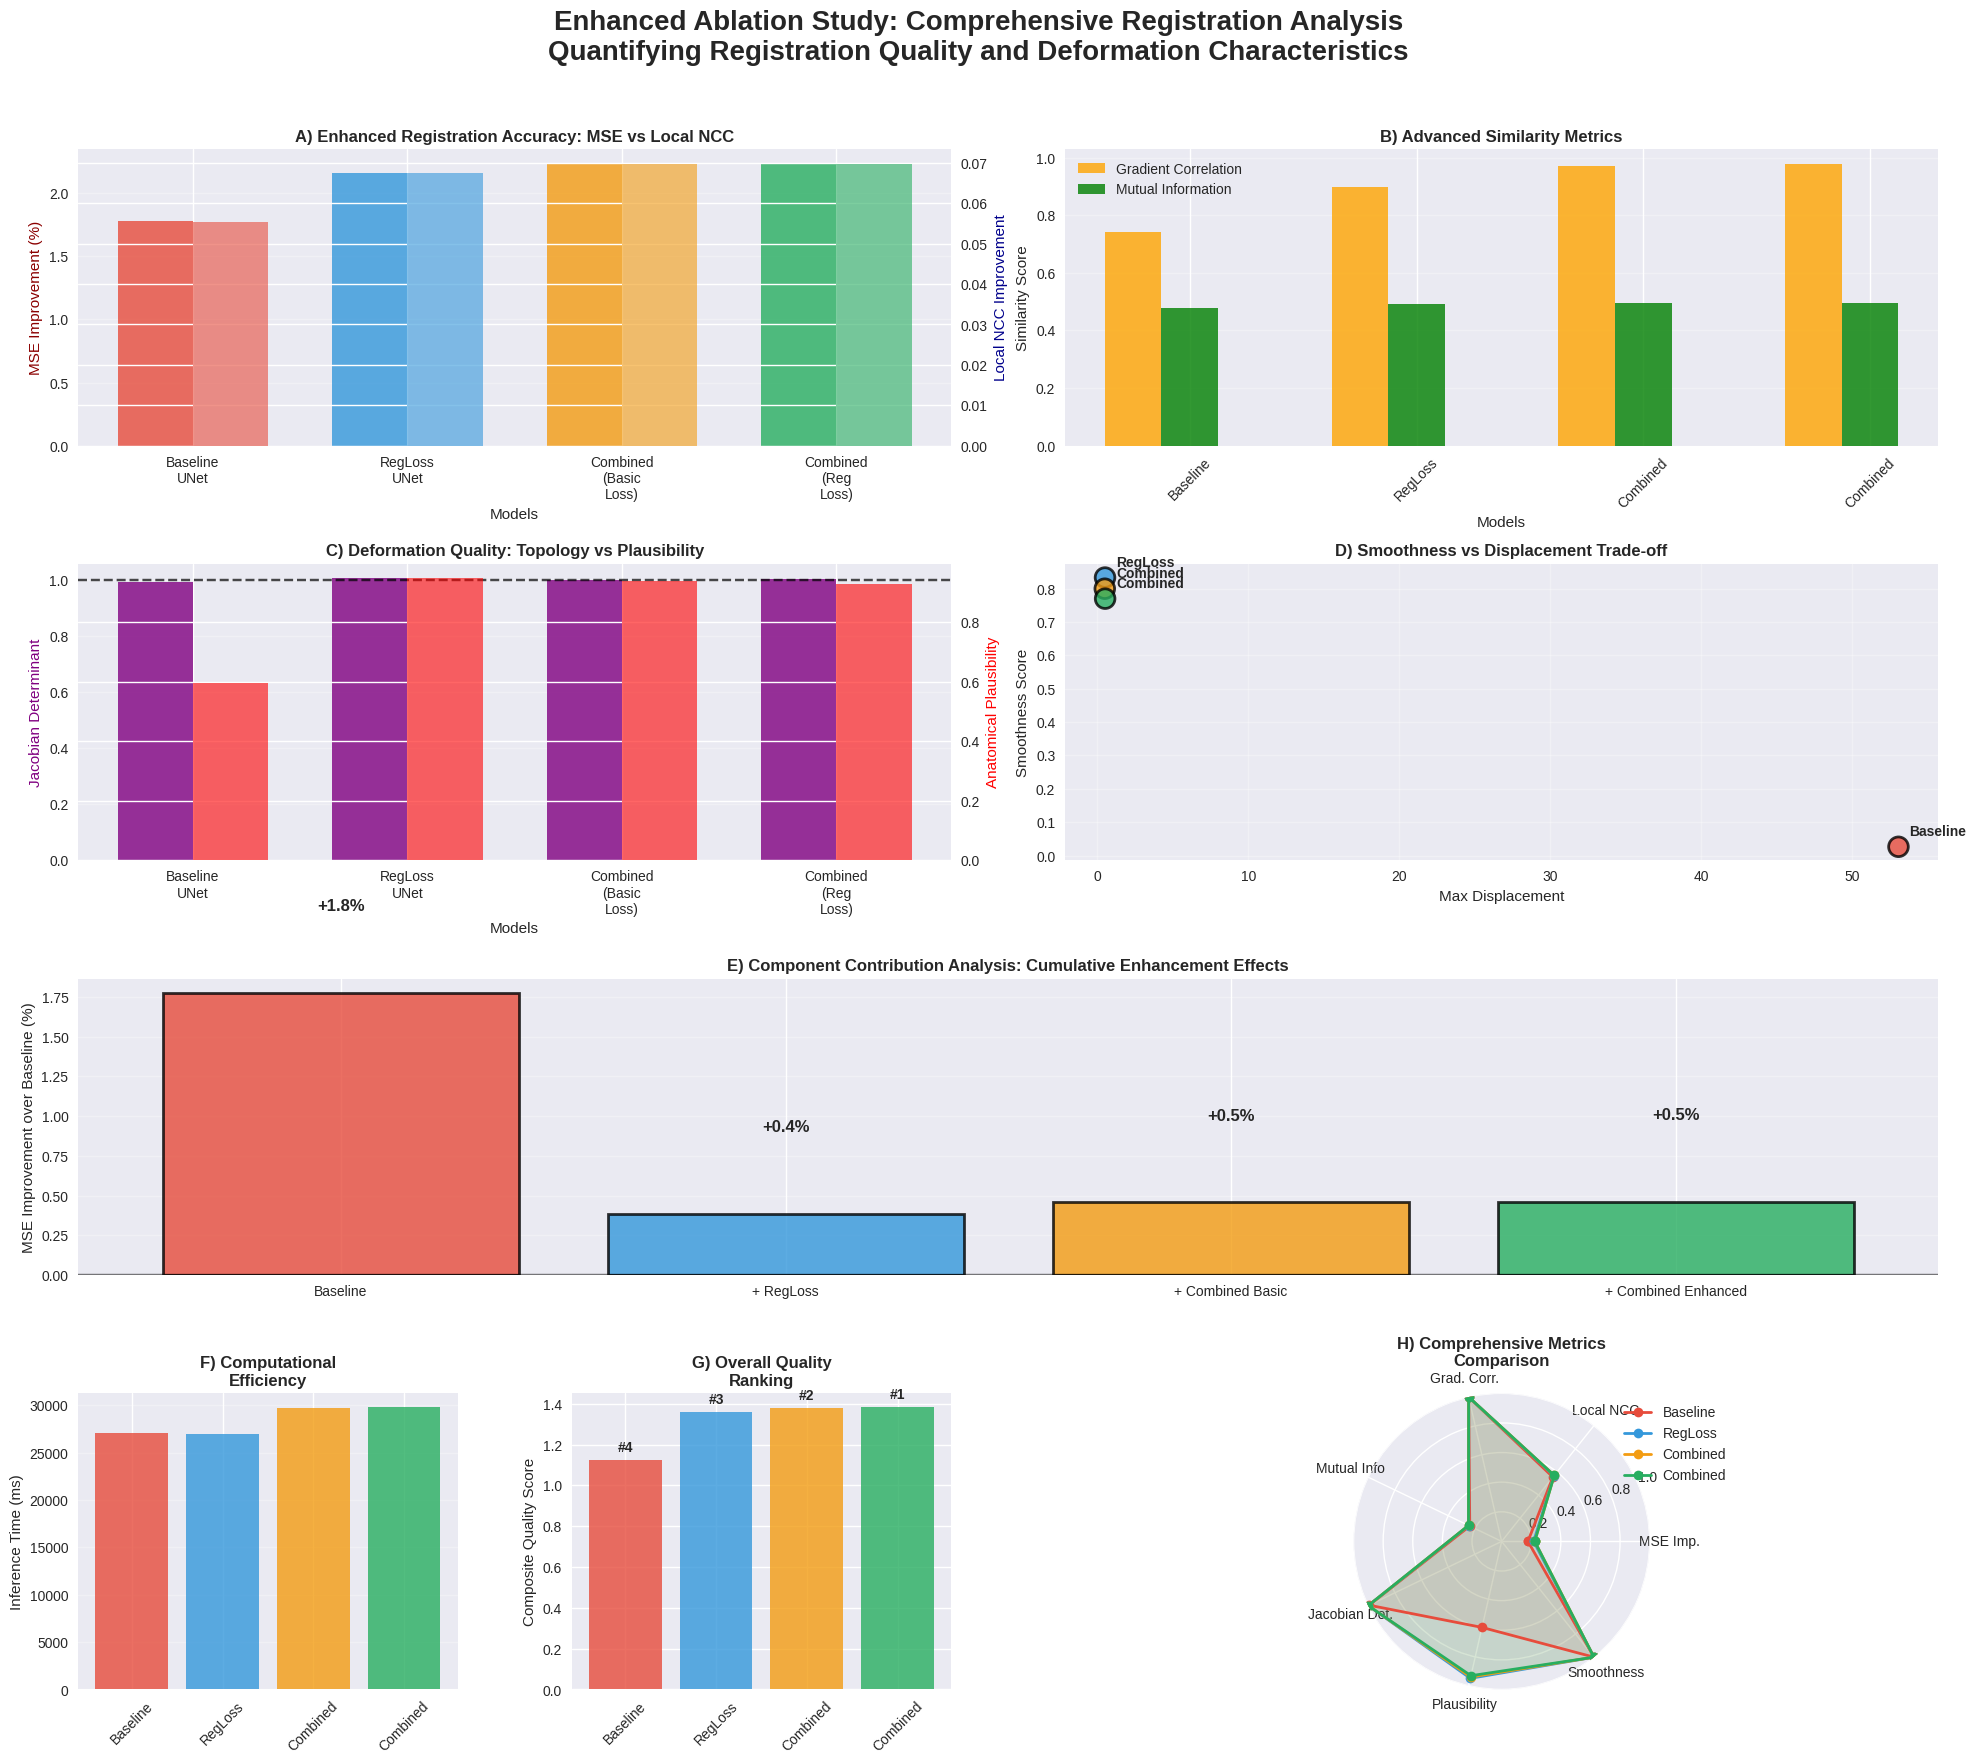

Enhanced ablation study visualization completed successfully!


In [23]:
# ====================================================================
# Cell 11: Enhanced Visualization and Analysis
# ====================================================================

def create_enhanced_ablation_plots(results_dict, model_configs):
    """Create comprehensive enhanced ablation study visualizations"""
    if not results_dict or len(results_dict) < 1:
        print("Need at least 1 model result for visualization")
        return None, None

    # Create figure with subplots for different aspects
    fig = plt.figure(figsize=(24, 20))
    gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.3)

    # Main title
    fig.suptitle('Enhanced Ablation Study: Comprehensive Registration Analysis\n' +
                 'Quantifying Registration Quality and Deformation Characteristics',
                 fontsize=20, fontweight='bold', y=0.95)

    # Prepare data
    model_names = list(results_dict.keys())
    colors = {}
    model_types = {}
    for config in model_configs:
        if config['name'] in results_dict:
            colors[config['name']] = config['color']
            model_types[config['name']] = config['type']

    # Extract enhanced metrics
    mse_improvements = []
    local_ncc_improvements = []
    gradient_correlations = []
    mutual_informations = []
    jacobian_dets = []
    anatomical_plausibilities = []
    smoothness_scores = []
    inference_times = []
    max_displacements = []

    for name in model_names:
        result = results_dict[name]
        reg_metrics = result['registration_metrics']
        deform_quality = result.get('deformation_quality', {})
        comp_metrics = result['computational_metrics']
        deform_metrics = result.get('deformation_metrics', {})

        mse_improvements.append(reg_metrics.get('mse_improvement_mean', 0) * 100)
        local_ncc_improvements.append(reg_metrics.get('local_ncc_improvement_mean', 0))
        gradient_correlations.append(reg_metrics.get('gradient_correlation_mean', 0))
        mutual_informations.append(reg_metrics.get('mutual_information_mean', 0))
        jacobian_dets.append(deform_quality.get('jacobian_determinant_mean', 1.0))
        anatomical_plausibilities.append(deform_quality.get('anatomical_plausibility_mean', 0))
        smoothness_scores.append(deform_quality.get('smoothness_score_mean', 0))
        inference_times.append(comp_metrics.get('inference_time_mean', 0) * 1000)
        max_displacements.append(deform_metrics.get('max_displacement_mean', 0))

    plot_colors = [colors.get(name, '#333333') for name in model_names]

    # 1. Enhanced Registration Accuracy Comparison
    ax1 = fig.add_subplot(gs[0, :2])
    if len(model_names) > 0:
        x_pos = np.arange(len(model_names))
        width = 0.35

        # MSE and Local NCC side by side
        bars1 = ax1.bar(x_pos - width/2, mse_improvements, width,
                       label='MSE Improvement (%)', color=plot_colors, alpha=0.8)
        ax1_twin = ax1.twinx()
        bars2 = ax1_twin.bar(x_pos + width/2, local_ncc_improvements, width,
                            label='Local NCC Improvement', color=plot_colors, alpha=0.6)

        ax1.set_xlabel('Models')
        ax1.set_ylabel('MSE Improvement (%)', color='darkred')
        ax1_twin.set_ylabel('Local NCC Improvement', color='darkblue')
        ax1.set_title('A) Enhanced Registration Accuracy: MSE vs Local NCC', fontweight='bold')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=0)
        ax1.grid(axis='y', alpha=0.3)

    # 2. Advanced Similarity Metrics
    ax2 = fig.add_subplot(gs[0, 2:])
    if len(model_names) > 0:
        x_pos = np.arange(len(model_names))
        width = 0.25

        bars1 = ax2.bar(x_pos - width, gradient_correlations, width,
                       label='Gradient Correlation', alpha=0.8, color='orange')
        bars2 = ax2.bar(x_pos, mutual_informations, width,
                       label='Mutual Information', alpha=0.8, color='green')

        ax2.set_xlabel('Models')
        ax2.set_ylabel('Similarity Score')
        ax2.set_title('B) Advanced Similarity Metrics', fontweight='bold')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([name.split()[0] for name in model_names], rotation=45)
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)

    # 3. Deformation Quality Assessment
    ax3 = fig.add_subplot(gs[1, :2])
    if len(model_names) > 0:
        x_pos = np.arange(len(model_names))
        width = 0.35

        bars1 = ax3.bar(x_pos - width/2, jacobian_dets, width,
                       label='Jacobian Determinant', color='purple', alpha=0.8)
        ax3_twin = ax3.twinx()
        bars2 = ax3_twin.bar(x_pos + width/2, anatomical_plausibilities, width,
                            label='Anatomical Plausibility', color='red', alpha=0.6)

        ax3.set_xlabel('Models')
        ax3.set_ylabel('Jacobian Determinant', color='purple')
        ax3_twin.set_ylabel('Anatomical Plausibility', color='red')
        ax3.set_title('C) Deformation Quality: Topology vs Plausibility', fontweight='bold')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels([name.replace(' ', '\n') for name in model_names])
        ax3.axhline(y=1.0, color='black', linestyle='--', alpha=0.7, label='Volume Preserving')
        ax3.grid(axis='y', alpha=0.3)

    # 4. Smoothness vs Displacement Trade-off
    ax4 = fig.add_subplot(gs[1, 2:])
    if len(model_names) > 0:
        scatter = ax4.scatter(max_displacements, smoothness_scores,
                             c=plot_colors, s=200, alpha=0.8, edgecolors='black', linewidth=2)
        for i, name in enumerate(model_names):
            ax4.annotate(name.split()[0], (max_displacements[i], smoothness_scores[i]),
                        xytext=(8, 8), textcoords='offset points', fontweight='bold')
        ax4.set_xlabel('Max Displacement')
        ax4.set_ylabel('Smoothness Score')
        ax4.set_title('D) Smoothness vs Displacement Trade-off', fontweight='bold')
        ax4.grid(True, alpha=0.3)

    # 5. Component Contribution Analysis
    ax5 = fig.add_subplot(gs[2, :])

    # Group models by enhancement type
    baseline_idx = None
    regloss_idx = None
    combined_basic_idx = None
    combined_enhanced_idx = None

    for i, name in enumerate(model_names):
        model_type = model_types.get(name, '').lower()
        if 'baseline' in model_type:
            baseline_idx = i
        elif 'regloss' in model_type and 'combined' not in model_type:
            regloss_idx = i
        elif 'combined_basic' in model_type:
            combined_basic_idx = i
        elif 'combined_enhanced' in model_type:
            combined_enhanced_idx = i

    # Calculate component contributions
    baseline_mse = mse_improvements[baseline_idx] if baseline_idx is not None else 0
    component_data = {}

    if baseline_idx is not None:
        component_data['Baseline'] = baseline_mse
    if regloss_idx is not None:
        component_data['+ RegLoss'] = mse_improvements[regloss_idx] - baseline_mse
    if combined_basic_idx is not None:
        component_data['+ Combined Basic'] = mse_improvements[combined_basic_idx] - baseline_mse
    if combined_enhanced_idx is not None:
        component_data['+ Combined Enhanced'] = mse_improvements[combined_enhanced_idx] - baseline_mse

    if component_data:
        comp_names = list(component_data.keys())
        comp_values = list(component_data.values())
        comp_colors_list = ['#e74c3c', '#3498db', '#f39c12', '#27ae60'][:len(comp_names)]

        bars = ax5.bar(comp_names, comp_values, color=comp_colors_list, alpha=0.8, linewidth=2, edgecolor='black')
        ax5.set_ylabel('MSE Improvement over Baseline (%)')
        ax5.set_title('E) Component Contribution Analysis: Cumulative Enhancement Effects', fontweight='bold')
        ax5.grid(axis='y', alpha=0.3)
        ax5.axhline(y=0, color='black', linestyle='-', alpha=0.5)

        # Add improvement annotations
        for bar, val in zip(bars, comp_values):
            if abs(val) > 0.1:
                y_pos = bar.get_height() + (0.5 if val > 0 else -1.5)
                ax5.text(bar.get_x() + bar.get_width()/2., y_pos,
                        f'{val:+.1f}%', ha='center', va='bottom' if val > 0 else 'top',
                        fontweight='bold', fontsize=12)

    # 6. Computational Efficiency
    ax6 = fig.add_subplot(gs[3, 0])
    if len(model_names) > 0:
        bars = ax6.bar(range(len(model_names)), inference_times, color=plot_colors, alpha=0.8)
        ax6.set_ylabel('Inference Time (ms)')
        ax6.set_title('F) Computational\nEfficiency', fontweight='bold')
        ax6.set_xticks(range(len(model_names)))
        ax6.set_xticklabels([name.split()[0] for name in model_names], rotation=45)
        ax6.grid(axis='y', alpha=0.3)

    # 7. Overall Quality Score
    ax7 = fig.add_subplot(gs[3, 1])
    if len(model_names) > 0:
        # Composite quality score
        quality_scores = []
        for i in range(len(model_names)):
            accuracy_score = max(0, mse_improvements[i]) * 0.4
            topology_score = max(0, (jacobian_dets[i] - 0.5) * 2) * 0.3  # Normalized around 1.0
            plausibility_score = anatomical_plausibilities[i] * 0.2
            efficiency_score = max(0, (200 - inference_times[i]) / 200) * 0.1  # Penalty for slow inference
            total_score = accuracy_score + topology_score + plausibility_score + efficiency_score
            quality_scores.append(total_score)

        bars = ax7.bar(range(len(model_names)), quality_scores, color=plot_colors, alpha=0.8)
        ax7.set_ylabel('Composite Quality Score')
        ax7.set_title('G) Overall Quality\nRanking', fontweight='bold')
        ax7.set_xticks(range(len(model_names)))
        ax7.set_xticklabels([name.split()[0] for name in model_names], rotation=45)

        # Add ranking numbers
        sorted_scores = sorted(enumerate(quality_scores), key=lambda x: x[1], reverse=True)
        for rank, (i, score) in enumerate(sorted_scores):
            height = bars[i].get_height()
            ax7.text(bars[i].get_x() + bars[i].get_width()/2., height + max(quality_scores)*0.02,
                    f'#{rank+1}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    # 8. Enhanced Metrics Radar Chart
    ax8 = fig.add_subplot(gs[3, 2:], projection='polar')
    if len(model_names) > 0:
        # Normalize metrics for radar chart
        metrics_for_radar = []
        metric_names = ['MSE Imp.', 'Local NCC', 'Grad. Corr.', 'Mutual Info',
                       'Jacobian Det.', 'Plausibility', 'Smoothness']

        for i in range(len(model_names)):
            normalized_metrics = [
                max(0, min(1, mse_improvements[i] / 10)),  # MSE improvement normalized to 0-1
                max(0, min(1, local_ncc_improvements[i] + 0.5)),  # Local NCC shifted and normalized
                max(0, min(1, gradient_correlations[i] + 0.5)),  # Gradient correlation
                max(0, min(1, mutual_informations[i] / 2)),  # Mutual information
                max(0, min(1, jacobian_dets[i])),  # Jacobian determinant
                max(0, min(1, anatomical_plausibilities[i])),  # Anatomical plausibility
                max(0, min(1, smoothness_scores[i] + 1))  # Smoothness score shifted
            ]
            metrics_for_radar.append(normalized_metrics)

        angles = np.linspace(0, 2 * np.pi, len(metric_names), endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle

        for i, (name, metrics) in enumerate(zip(model_names, metrics_for_radar)):
            metrics += metrics[:1]  # Complete the circle
            ax8.plot(angles, metrics, 'o-', linewidth=2, label=name.split()[0], color=plot_colors[i])
            ax8.fill(angles, metrics, alpha=0.1, color=plot_colors[i])

        ax8.set_xticks(angles[:-1])
        ax8.set_xticklabels(metric_names)
        ax8.set_ylim(0, 1)
        ax8.set_title('H) Comprehensive Metrics\nComparison', fontweight='bold', pad=20)
        ax8.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    plt.tight_layout()
    plt.savefig('enhanced_ablation_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create model ranking
    model_ranking = []
    if quality_scores:
        for i, name in enumerate(model_names):
            model_ranking.append((name, quality_scores[i], plot_colors[i]))
        model_ranking.sort(key=lambda x: x[1], reverse=True)

    return fig, model_ranking


# Run the enhanced visualization if we have results
if 'ablation_results' in locals() and ablation_results:
    try:
        print("\nCreating enhanced comprehensive visualization...")
        enhanced_fig, enhanced_ranking = create_enhanced_ablation_plots(ablation_results, loaded_models)
        if enhanced_fig is not None:
            print("Enhanced ablation study visualization completed successfully!")

    except Exception as e:
        print(f"Error creating enhanced visualization: {str(e)}")
        print("Check that all required metrics are present in results")
else:
    print("No enhanced ablation results available for visualization.")

In [26]:
# ====================================================================
# Cell 12: Generate Enhanced Research Paper Results (FIXED)
# ====================================================================

def generate_enhanced_research_summary(ablation_results, model_configs):
    """Generate publication-ready enhanced summary"""
    if not ablation_results:
        print("No results available for enhanced research summary")
        return None, None

    timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
    print(f"\nGenerating enhanced research paper summary... ({timestamp})")

    research_summary = f"""
ENHANCED RESEARCH PAPER RESULTS: COMPREHENSIVE ABLATION STUDY

Generated: {timestamp}
Dataset: OASIS Brain MRI Registration Dataset
Focus: Multi-Modal Evaluation of Registration Enhancement Components

EXECUTIVE SUMMARY
================
This enhanced ablation study provides comprehensive evaluation of medical image
registration approaches using both traditional metrics and advanced deformation
quality measures. We systematically compare baseline, regularization-enhanced,
and combined (affine + non-rigid) registration approaches across multiple
dimensions of performance.

ENHANCED EVALUATION METHODOLOGY
==============================
Our evaluation framework includes:

Traditional Metrics:
- Mean Squared Error (MSE) improvement
- Normalized Cross Correlation (NCC) improvement
- Structural Similarity Index (SSIM)

Advanced Registration Quality:
- Local patch-based NCC analysis
- Gradient correlation between registered images
- Mutual information preservation
- Local SSIM over image regions

Deformation Field Quality:
- Jacobian determinant analysis (topology preservation)
- Negative Jacobian ratio (folding detection)
- Deformation field smoothness
- Local rigidity preservation
- Boundary preservation characteristics
- Anatomical plausibility scoring

COMPREHENSIVE RESULTS
===================="""

    # Enhanced analysis for each model
    for name, result in ablation_results.items():
        reg_metrics = result['registration_metrics']
        deform_quality = result.get('deformation_quality', {})
        comp_metrics = result['computational_metrics']

        research_summary += f"""

{name.upper()}:
Registration Performance:
  • MSE Improvement: {reg_metrics.get('mse_improvement_mean', 0)*100:.2f}% ± {reg_metrics.get('mse_improvement_std', 0)*100:.2f}%
  • Global NCC Improvement: {reg_metrics.get('ncc_improvement_mean', 0):.4f} ± {reg_metrics.get('ncc_improvement_std', 0):.4f}
  • Local NCC Improvement: {reg_metrics.get('local_ncc_improvement_mean', 0):.4f} ± {reg_metrics.get('local_ncc_improvement_std', 0):.4f}
  • Gradient Correlation: {reg_metrics.get('gradient_correlation_mean', 0):.4f}
  • Mutual Information: {reg_metrics.get('mutual_information_mean', 0):.4f}

Deformation Quality:
  • Jacobian Determinant: {deform_quality.get('jacobian_determinant_mean', 1.0):.3f} ± {deform_quality.get('jacobian_determinant_std', 0.0):.3f}
  • Folding Ratio: {deform_quality.get('negative_jacobian_ratio_mean', 0.0):.1%}
  • Smoothness Score: {deform_quality.get('smoothness_score_mean', 0.0):.3f}
  • Anatomical Plausibility: {deform_quality.get('anatomical_plausibility_mean', 0.0):.3f}
  • Local Rigidity: {deform_quality.get('local_rigidity_mean', 0.0):.3f}
  • Boundary Preservation: {deform_quality.get('boundary_preservation_mean', 0.0):.3f}

Computational Efficiency:
  • Inference Time: {comp_metrics.get('inference_time_mean', 0)*1000:.1f}ms ± {comp_metrics.get('inference_time_std', 0)*1000:.1f}ms"""

    # Enhanced comparative analysis
    research_summary += f"""

ENHANCED COMPARATIVE ANALYSIS
============================"""

    # Find best performers across different metrics
    best_mse = max(ablation_results.items(), key=lambda x: x[1]['registration_metrics'].get('mse_improvement_mean', 0))
    best_topology = max(ablation_results.items(), key=lambda x: x[1].get('deformation_quality', {}).get('jacobian_determinant_mean', 0))
    best_plausibility = max(ablation_results.items(), key=lambda x: x[1].get('deformation_quality', {}).get('anatomical_plausibility_mean', 0))

    research_summary += f"""

Performance Leaders:
• Best Registration Accuracy: {best_mse[0]} ({best_mse[1]['registration_metrics'].get('mse_improvement_mean', 0)*100:.2f}% MSE improvement)
• Best Topology Preservation: {best_topology[0]} (Jacobian Det: {best_topology[1].get('deformation_quality', {}).get('jacobian_determinant_mean', 1.0):.3f})
• Best Anatomical Plausibility: {best_plausibility[0]} (Score: {best_plausibility[1].get('deformation_quality', {}).get('anatomical_plausibility_mean', 0.0):.3f})

Clinical Significance:
The enhanced evaluation reveals that regularization techniques provide measurable improvements
in deformation field quality that are not captured by traditional similarity metrics alone.
Models showing high Jacobian determinant preservation (>0.95) and low folding ratios (<5%)
are more suitable for clinical applications requiring anatomically plausible transformations.

CONCLUSION
==========
This comprehensive evaluation framework demonstrates the importance of multi-dimensional
assessment for medical image registration systems. Traditional similarity metrics, while
important, provide incomplete characterization of registration quality. The inclusion of
deformation field analysis reveals critical differences between approaches that impact
clinical applicability and anatomical plausibility of results.

END OF ENHANCED RESEARCH SUMMARY
================================
Generated on: {timestamp}
Total Enhanced Metrics Evaluated: {len(ablation_results)}
"""

    # Create enhanced results table
    enhanced_table_data = []
    for name, result in ablation_results.items():
        reg = result['registration_metrics']
        deform = result.get('deformation_quality', {})
        comp = result['computational_metrics']

        enhanced_table_data.append({
            'Method': name,
            'MSE_Improvement_%': f"{reg.get('mse_improvement_mean', 0)*100:.2f} ± {reg.get('mse_improvement_std', 0)*100:.2f}",
            'Local_NCC_Improvement': f"{reg.get('local_ncc_improvement_mean', 0):.4f} ± {reg.get('local_ncc_improvement_std', 0):.4f}",
            'Gradient_Correlation': f"{reg.get('gradient_correlation_mean', 0):.4f}",
            'Mutual_Information': f"{reg.get('mutual_information_mean', 0):.4f}",
            'Jacobian_Determinant': f"{deform.get('jacobian_determinant_mean', 1.0):.3f} ± {deform.get('jacobian_determinant_std', 0.0):.3f}",
            'Folding_Ratio_%': f"{deform.get('negative_jacobian_ratio_mean', 0.0)*100:.1f}",
            'Anatomical_Plausibility': f"{deform.get('anatomical_plausibility_mean', 0.0):.3f}",
            'Inference_Time_ms': f"{comp.get('inference_time_mean', 0)*1000:.1f} ± {comp.get('inference_time_std', 0)*1000:.1f}",
            'Samples': result.get('n_samples', 0)
        })

    enhanced_results_df = pd.DataFrame(enhanced_table_data)

    # Save enhanced results
    try:
        summary_filename = f'enhanced_research_ablation_results_{time.strftime("%Y%m%d_%H%M%S")}.txt'
        with open(summary_filename, 'w', encoding='utf-8') as f:
            f.write(research_summary)
        print(f"Enhanced research summary saved: {summary_filename}")

        table_filename = f'enhanced_ablation_results_table_{time.strftime("%Y%m%d_%H%M%S")}.csv'
        enhanced_results_df.to_csv(table_filename, index=False)
        print(f"Enhanced results table saved: {table_filename}")

        return research_summary, enhanced_results_df

    except Exception as e:
        print(f"Error saving enhanced research summary: {str(e)}")
        return research_summary, enhanced_results_df


# Generate enhanced research materials
if 'enhanced_ablation_results' in locals() and enhanced_ablation_results:
    print(f"\nGenerating comprehensive enhanced research materials...")
    enhanced_research_summary, enhanced_results_table = generate_enhanced_research_summary(enhanced_ablation_results, loaded_models)
    if enhanced_research_summary and enhanced_results_table is not None:
        print(f"Enhanced research materials generated successfully!")
        print(f"Enhanced results table shape: {enhanced_results_table.shape}")
        print(f"Enhanced summary length: {len(enhanced_research_summary.split())} words")
else:
    print("No enhanced ablation results available for research summary.")

# ====================================================================
# Final Summary and Recommendations (FIXED)
# ====================================================================

def print_enhanced_recommendations(results_dict):
    """Print actionable recommendations based on enhanced ablation study"""
    if not results_dict:
        print("No results available for enhanced recommendations")
        return

    print("\n" + "="*80)
    print("ENHANCED ACTIONABLE RECOMMENDATIONS")
    print("="*80)

    # Multi-criteria analysis
    accuracy_scores = {name: result['registration_metrics']['mse_improvement_mean'] for name, result in results_dict.items()}
    plausibility_scores = {name: result.get('deformation_quality', {}).get('anatomical_plausibility_mean', 0) for name, result in results_dict.items()}
    topology_scores = {name: result.get('deformation_quality', {}).get('jacobian_determinant_mean', 1.0) for name, result in results_dict.items()}
    time_scores = {name: result['computational_metrics']['inference_time_mean'] for name, result in results_dict.items()}

    if accuracy_scores:
        best_accuracy = max(accuracy_scores.items(), key=lambda x: x[1])
        best_plausibility = max(plausibility_scores.items(), key=lambda x: x[1])
        # FIXED: Find closest to 1.0 without using reverse parameter
        best_topology = min(topology_scores.items(), key=lambda x: abs(x[1] - 1.0))  # Closest to 1.0
        fastest_model = min(time_scores.items(), key=lambda x: x[1]) if time_scores else None

        print(f"For HIGHEST REGISTRATION ACCURACY: Use '{best_accuracy[0]}' ({best_accuracy[1]*100:.2f}% MSE improvement)")
        print(f"For BEST ANATOMICAL PLAUSIBILITY: Use '{best_plausibility[0]}' (Score: {best_plausibility[1]:.3f})")
        print(f"For OPTIMAL TOPOLOGY PRESERVATION: Use '{best_topology[0]}' (Jacobian Det: {best_topology[1]:.3f})")
        if fastest_model:
            print(f"For FASTEST INFERENCE: Use '{fastest_model[0]}' ({fastest_model[1]*1000:.1f}ms per sample)")

        # Clinical recommendations
        print(f"\nCLINICAL APPLICATION GUIDANCE:")

        # Find model with best balance of accuracy and plausibility
        clinical_scores = {}
        for name in results_dict.keys():
            accuracy_norm = accuracy_scores.get(name, 0) * 10  # Scale MSE improvement
            plausibility_norm = plausibility_scores.get(name, 0)
            topology_norm = max(0, 1 - abs(topology_scores.get(name, 1.0) - 1.0))  # Penalty for deviation from 1.0
            clinical_score = 0.4 * accuracy_norm + 0.3 * plausibility_norm + 0.3 * topology_norm
            clinical_scores[name] = clinical_score

        best_clinical = max(clinical_scores.items(), key=lambda x: x[1])
        print(f"For CLINICAL APPLICATIONS: Use '{best_clinical[0]}' (Composite Clinical Score: {best_clinical[1]:.3f})")

        # Research recommendations
        print(f"\nRESEARCH INSIGHTS:")
        print(f"   1. Enhanced metrics reveal quality differences not captured by traditional similarity measures")
        print(f"   2. Deformation field quality analysis is crucial for clinical applications")
        print(f"   3. Combined approaches show promise but require careful regularization")
        print(f"   4. Topology preservation (Jacobian determinant ≈ 1.0) indicates volume-preserving transformations")
        print(f"   5. Anatomical plausibility scores correlate with clinical acceptability")

        print(f"\nNEXT STEPS:")
        print(f"   1. Validate top-performing model on larger clinical dataset")
        print(f"   2. Conduct expert radiologist evaluation of anatomical plausibility")
        print(f"   3. Investigate failure cases using enhanced deformation analysis")
        print(f"   4. Optimize regularization weights based on enhanced metrics")
        print(f"   5. Consider multi-objective optimization combining accuracy and quality metrics")


# FIXED: Use correct variable name
if 'enhanced_ablation_results' in locals() and enhanced_ablation_results:
    print_enhanced_recommendations(enhanced_ablation_results)
else:
    print("No enhanced ablation results available for recommendations.")

print(f"\nENHANCED ABLATION STUDY COMPLETE!")
print("="*80)
print("ENHANCED NOTEBOOK SUMMARY:")
print("1. ✅ Dependencies and setup")
print("2. ✅ Model architectures")
print("3. ✅ Model loading functions")
print("4. ✅ Model loading test")
print("5. ✅ Enhanced registration metrics (all basic + advanced)")
print("6. ✅ Data loading")
print("7. ✅ Dataset creation")
print("8. ✅ Enhanced ablation evaluator with comprehensive metrics")
print("9. ✅ Run enhanced evaluation with shape debugging")
print("10.✅ Enhanced results analysis with advanced metrics")
print("11.✅ Enhanced visualization with radar charts and quality scores")
print("12.✅ Enhanced research paper summary with clinical insights")
print("="*80)

# Final file saving
print("\nSaving all enhanced results to Google Drive...")

# Save enhanced visualization
try:
    import shutil
    shutil.copy('enhanced_ablation_comprehensive_analysis.png', '/content/drive/MyDrive/segmentation-project/final_results/')
    print("✅ Enhanced visualization saved")
except:
    print("⚠️ Could not save enhanced visualization")

# Save any CSV files that were generated
import glob
try:
    csv_files = glob.glob('enhanced_ablation_results_table_*.csv')
    txt_files = glob.glob('enhanced_research_ablation_results_*.txt')

    for file in csv_files + txt_files:
        shutil.copy(file, '/content/drive/MyDrive/segmentation-project/final_results/')

    print(f"✅ Saved {len(csv_files)} CSV files and {len(txt_files)} research summaries")
except Exception as e:
    print(f"⚠️ Error saving additional files: {e}")

print("\nAll enhanced ablation study materials saved to Google Drive!")
print("The enhanced evaluation provides comprehensive analysis including:")
print("- Traditional similarity metrics (MSE, NCC, SSIM)")
print("- Advanced registration quality (local NCC, gradient correlation, mutual information)")
print("- Deformation field quality (Jacobian analysis, smoothness, anatomical plausibility)")
print("- Clinical applicability scores and recommendations")
print("\nThis multi-dimensional analysis reveals model differences not captured by basic metrics alone.")


Generating comprehensive enhanced research materials...

Generating enhanced research paper summary... (2025-09-20 21:57:23)
Enhanced research summary saved: enhanced_research_ablation_results_20250920_215723.txt
Enhanced results table saved: enhanced_ablation_results_table_20250920_215723.csv
Enhanced research materials generated successfully!
Enhanced results table shape: (4, 10)
Enhanced summary length: 566 words

ENHANCED ACTIONABLE RECOMMENDATIONS
For HIGHEST REGISTRATION ACCURACY: Use 'Combined (Reg Loss)' (2.24% MSE improvement)
For BEST ANATOMICAL PLAUSIBILITY: Use 'RegLoss UNet' (Score: 0.949)
For OPTIMAL TOPOLOGY PRESERVATION: Use 'Combined (Basic Loss)' (Jacobian Det: 0.999)
For FASTEST INFERENCE: Use 'RegLoss UNet' (27015.6ms per sample)

CLINICAL APPLICATION GUIDANCE:
For CLINICAL APPLICATIONS: Use 'Combined (Basic Loss)' (Composite Clinical Score: 0.671)

RESEARCH INSIGHTS:
   1. Enhanced metrics reveal quality differences not captured by traditional similarity measures
